# ISO-DEM : ISOPARAMETRIC DOMAIN DEEP ENERGY METHOD

In [24]:
# Link to install debugger in jupyterlab
# First, we have to upgrade jupyterlab to 2.0 version & install nodejs and npm by
# 1. conda update -c conda-forge jupyterlab
# 2. pip install npm
# 3. conda install nodejs
# Second, we have to install debugger extension for notebooklab (https://blog.jupyter.org/a-visual-debugger-for-jupyter-914e61716559)
# Front-end tool:
# jupyter labextension install @jupyterlab/debugger
# Back-end tool:
# conda install xeus-python -c conda-forge
# Please, change the kernel to XPython before using and restart everything.
# If everything does not work, please read the article below for fixing issues
# https://stackoverflow.com/questions/61888748/extension-installation-error-please-install-nodejs-5-and-npm-before-continuing

In [25]:
"""
@author: sfmt4368, texa5140, minh.nguyen@ikm.uni-hannover.de
Implements strain gradient elasticity
"""

from torch.autograd import grad
import numpy as np
import numpy.random as npr
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from mpl_toolkits.mplot3d import Axes3D
from pyevtk.hl import gridToVTK
import time
import torch
import math
from geomdl import NURBS
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
import scipy.special as sp
from numpy import sqrt
import sys
mpl.rcParams['figure.dpi'] = 250
axes = {'labelsize': 'large'}
font = {'family': 'serif',
        'weight': 'normal',
        'size': 5}
legend = {'fontsize': 'medium'}
lines = {'linewidth': 3,
         'markersize': 7}

mpl.rc('font', **font)
mpl.rc('axes', **axes)
mpl.rc('legend', **legend)
mpl.rc('lines', **lines)

dev = torch.device('cpu')
npr.seed(2019)
torch.manual_seed(2019)

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

if torch.cuda.is_available():
    print("CUDA is available, running on GPU")
    dev = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    print("CUDA not available, running on CPU")
    
path_save_pic = "./output/plate/"

CUDA is available, running on GPU


## <u>Example 1</u>: Plate with a hole

## Exact solution

In [26]:
def cart2pol(x, y):
    rho = np.sqrt(np.array(x)**2 + np.array(y)**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
    
def uexact_plate(x, y, problem_param):
    r, th = cart2pol(x,y)
    E = problem_param['E']
    nu = problem_param['nu']
    R = problem_param['radInt']
    tx = problem_param['P']
    u_exact = (1+nu)/E*tx*(1/(1+nu)*r*np.cos(th)+2*R**2/((1+nu)*r)*np.cos(th)+ \
        R**2/(2*r)*np.cos(3*th)-R**4/(2*r**3)*np.cos(3*th))
    v_exact = (1+nu)/E*tx*(-nu/(1+nu)*r*np.sin(th)-(1-nu)*R**2/((1+nu)*r)*np.sin(th)+ \
        R**2/(2*r)*np.sin(3*th)-R**4/(2*r**3)*np.sin(3*th))                        
    return u_exact, v_exact

def sigma_exact_plate(x, y, problem_param):
    numPts = len(x)
    sigma_xx = np.zeros_like(x)
    sigma_yy = np.zeros_like(x)
    sigma_xy = np.zeros_like(x)
    for i in range(numPts):
        r, th = cart2pol(x[i],y[i])
    
        R = problem_param['radInt']
        tx = problem_param['P']
        
        stressrr = tx/2*(1-R**2/r**2)+tx/2*(1-4*R**2/r**2+3*R**4/r**4)*np.cos(2*th)
        stresstt = tx/2*(1+R**2/r**2)-tx/2*(1+3*R**4/r**4)*np.cos(2*th)
        stressrt = -tx/2*(1+2*R**2/r**2-3*R**4/r**4)*np.sin(2*th)
        
        A = np.array([[np.cos(th)**2, np.sin(th)**2, 2*np.sin(th)*np.cos(th)],
                       [np.sin(th)**2, np.cos(th)**2, -2*np.sin(th)*np.cos(th)],
                       [-np.sin(th)*np.cos(th), np.sin(th)*np.cos(th), 
                        np.cos(th)**2-np.sin(th)**2]])
        A = np.reshape(A, (3,3))        
        stress = np.linalg.solve(A,np.array([stressrr,stresstt,stressrt]))
        sigma_xx[i] = stress[0]
        sigma_yy[i] = stress[1]
        sigma_xy[i] = stress[2]
    return np.concatenate((sigma_xx, sigma_yy, sigma_xy), axis=1)                       

def getExactStresses(x, y, problem_param):
    numPts = len(x)
    sigma_xx = np.zeros_like(x)
    sigma_yy = np.zeros_like(x)
    sigma_xy = np.zeros_like(x)
    for i in range(numPts):
        r, th = cart2pol(x[i],y[i])
    
        R = problem_param['radInt']
        tx = problem_param['P']
        
        stressrr = tx/2*(1-R**2/r**2)+tx/2*(1-4*R**2/r**2+3*R**4/r**4)*np.cos(2*th)
        stresstt = tx/2*(1+R**2/r**2)-tx/2*(1+3*R**4/r**4)*np.cos(2*th)
        stressrt = -tx/2*(1+2*R**2/r**2-3*R**4/r**4)*np.sin(2*th)
        
        A = np.array([[np.cos(th)**2, np.sin(th)**2, 2*np.sin(th)*np.cos(th)],
                       [np.sin(th)**2, np.cos(th)**2, -2*np.sin(th)*np.cos(th)],
                       [-np.sin(th)*np.cos(th), np.sin(th)*np.cos(th), 
                        np.cos(th)**2-np.sin(th)**2]])   
        stress = np.linalg.solve(A,np.array([stressrr,stresstt,stressrt]))
        sigma_xx[i] = stress[0]
        sigma_yy[i] = stress[1]
        sigma_xy[i] = stress[2]
    return sigma_xx, sigma_yy, sigma_xy

def getExactTraction(x, y, xNorm, yNorm, problem_param):    
    sigma_xx, sigma_yy, sigma_xy = getExactStresses(x[:,0], y[:,0], problem_param)
    sigma_xx = np.expand_dims(sigma_xx, axis=1)
    sigma_yy = np.expand_dims(sigma_yy, axis=1)
    sigma_xy = np.expand_dims(sigma_xy, axis=1)
    trac_x = xNorm[:,0:1]*sigma_xx + yNorm[:,0:1]*sigma_xy
    trac_y = xNorm[:,0:1]*sigma_xy + yNorm[:,0:1]*sigma_yy
    return trac_x, trac_y

def Moduli(mu, lmbda):
    # Plane stress
    return 2*mu / (2*mu + lmbda) * np.array([[2*(mu+lmbda), lmbda, 0],
                                    [lmbda, 2*(mu+lmbda), 0],
                                    [0, 0, (2*mu + lmbda)/2]])

def eps_exact_plate(mu, lmbda, stress):
    eps = np.zeros_like(stress)
    C = Moduli(mu, lmbda)
    for i, e in enumerate(stress):
        sigma = np.expand_dims(e, axis=1)
        r = np.matmul(np.linalg.inv(C), sigma)
        eps[i, : ] = np.reshape(r, (1, 3))
    return eps

### Step 1: GEOMETRY ISODEM

In [27]:
class GeometryISO2D:
    '''
     Base class for 2D domains
     Input: geomData - dictionary containing the geomety information
     Keys: degree_u, degree_v: polynomial degree in the u and v directions
       ctrlpts_size_u, ctrlpts_size_v: number of control points in u,v directions
       ctrlpts: weighted control points (in a list with
            ctrlpts_size_u*ctrlpts_size_v rows and 3 columns for x,y,z coordinates)
       weights: correspond weights (list with ctrlpts_size_u*ctrlpts_size_v entries)
       knotvector_u, knotvector_v: knot vectors in the u and v directions
    '''

    def __init__(self, geomData):
        self.surf = NURBS.Surface()
        self.surf.degree_u = geomData['degree_u']
        self.surf.degree_v = geomData['degree_v']
        self.surf.ctrlpts_size_u = geomData['ctrlpts_size_u']
        self.surf.ctrlpts_size_v = geomData['ctrlpts_size_v']
        self.surf.ctrlpts = self.getUnweightedCpts(geomData['ctrlpts'],
                                                   geomData['weights'])
        self.surf.weights = geomData['weights']
        self.surf.knotvector_u = geomData['knotvector_u']
        self.surf.knotvector_v = geomData['knotvector_v']
        
    def getUnweightedCpts(self, ctrlpts, weights):
        numCtrlPts = np.shape(ctrlpts)[0]
        PctrlPts = np.zeros_like(ctrlpts)
        for i in range(3):
            for j in range(numCtrlPts):
                PctrlPts[j, i] = ctrlpts[j][i] / weights[j]
        PctrlPts = PctrlPts.tolist()
        return PctrlPts

    def mapPoints(self, uPar, vPar):
        '''
        Map points from the parameter domain [0,1]x[0,1] to the quadrilater domain
        Input:  uPar - array containing the u-coordinates in the parameter space
                vPar - array containing the v-coordinates in the parameter space
                Note: the arrays uPar and vPar must be of the same size
        Output: xPhys - array containing the x-coordinates in the physical space
                yPhys - array containing the y-coordinates in the physical space
        '''
        gpParamUV = np.array([uPar, vPar])
        evalList = tuple(map(tuple, gpParamUV.transpose()))
        res = np.array(self.surf.evaluate_list(evalList))

        return res

    def getUnifIntPts(self, numPtsU, numPtsV, withEdges):
        '''
        Generate uniformly spaced points inside the domain
        Input: numPtsU, numPtsV - number of points (including edges) in the u and v
                   directions in the parameter space
               withEdges - 1x4 array of zeros or ones specifying whether the boundary points
                           should be included. The boundary order is [bottom, right,
                           top, left] for the unit square.
        Output: xM, yM - flattened array containing the x and y coordinates of the points
        '''
        # generate points in the x direction on the interval [0,1]
        uEdge = np.linspace(0, 1, numPtsU)
        vEdge = np.linspace(0, 1, numPtsV)

        # remove endpoints depending on values of withEdges
        if withEdges[0] == 0:
            vEdge = vEdge[1:]
        if withEdges[1] == 0:
            uEdge = uEdge[:-1]
        if withEdges[2] == 0:
            vEdge = vEdge[:-1]
        if withEdges[3] == 0:
            uEdge = uEdge[1:]

        # create meshgrid
        uPar, vPar = np.meshgrid(uEdge, vEdge)

        uPar = uPar.flatten()
        vPar = vPar.flatten()
        # map points
        res = self.mapPoints(uPar.T, vPar.T)

        xPhys = res[:, 0:1]
        yPhys = res[:, 1:2]

        return xPhys, yPhys

    def getQuadIntPts(self, numElemU, numElemV, numGauss):
        '''
        Generate quadrature points inside the domain
        Input: numElemU, numElemV - number of subdivisions in the u and v
                   directions in the parameter space
               numGauss - number of Gauss quadrature points for each subdivision
        Output: xPhys, yPhys, wgtPhy - arrays containing the x and y coordinates
                                    of the points and the corresponding weights
        '''
        # allocate quadPts array
        quadPts = np.zeros((numElemU * numElemV * numGauss ** 2, 3))
        dxidx = np.zeros((numElemU * numElemV * numGauss ** 2, 4))
        # get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)

        # get the Gauss weights on the reference element [-1, 1]x[-1,1]
        gpWeightU, gpWeightV = np.meshgrid(gw, gw)
        gpWeightUV = np.array(gpWeightU.flatten() * gpWeightV.flatten())

        # generate the knots on the interval [0,1]
        uEdge = np.linspace(0, 1, numElemU + 1)
        vEdge = np.linspace(0, 1, numElemV + 1)

        # create meshgrid
        uPar, vPar = np.meshgrid(uEdge, vEdge)
        gpUV = np.empty((0, 2), float)
        # generate points for each element
        indexPt = 0
        for iV in range(numElemV):
            for iU in range(numElemU):
                uMin = uPar[iV, iU]
                uMax = uPar[iV, iU + 1]
                vMin = vPar[iV, iU]
                vMax = vPar[iV + 1, iU]
                gpParamU = (uMax - uMin) / 2 * gp + (uMax + uMin) / 2
                gpParamV = (vMax - vMin) / 2 * gp + (vMax + vMin) / 2
                gpUV = np.append(gpUV, np.array([gpParamU, gpParamV]).T, axis=0)
                gpParamUg, gpParamVg = np.meshgrid(gpParamU, gpParamV)
                gpParamUV = np.array([gpParamUg.flatten(), gpParamVg.flatten()])
                # Jacobian of the transformation from the reference element [-1,1]x[-1,1]
                scaleFac = (uMax - uMin) * (vMax - vMin) / 4

                # map the points to the physical space
                for iPt in range(numGauss ** 2):
                    curPtU = gpParamUV[0, iPt]
                    curPtV = gpParamUV[1, iPt]
                    derivMat = self.surf.derivatives(curPtU, curPtV, order=1)
                    physPtX = derivMat[0][0][0]
                    physPtY = derivMat[0][0][1]
                    derivU = derivMat[1][0][0:2]
                    derivV = derivMat[0][1][0:2]
                    JacobMat = np.array([derivU, derivV])
                    detJac = np.linalg.det(JacobMat)
                    quadPts[indexPt, 0] = physPtX
                    quadPts[indexPt, 1] = physPtY
                    quadPts[indexPt, 2] = scaleFac * detJac * gpWeightUV[iPt]
                    # dxi1/dx = 1/detJac * dy/dxi2
                    dxidx[indexPt, 0] =  1 / detJac * derivV[1]
                    # dxi1/dx = 1/detJac * -dy/dxi1
                    dxidx[indexPt, 1] = -1 / detJac * derivU[1]
                    # dxi1/dx = 1/detJac * -dx/dxi2
                    dxidx[indexPt, 2] = -1 / detJac * derivV[0]
                    # dxi1/dx = 1/detJac * dx/dxi1
                    dxidx[indexPt, 3] =  1 / detJac * derivU[0]
                    indexPt = indexPt + 1

        xPhys = quadPts[:, 0:1]
        yPhys = quadPts[:, 1:2]
        wgtPhys = quadPts[:, 2:3]

        return xPhys, yPhys, wgtPhys , gpUV, dxidx

    def getUnweightedCpts2d(self, ctrlpts2d, weights):
        numCtrlPtsU = np.shape(ctrlpts2d)[0]
        numCtrlPtsV = np.shape(ctrlpts2d)[1]
        PctrlPts = np.zeros([numCtrlPtsU, numCtrlPtsV, 3])
        counter = 0
        for j in range(numCtrlPtsU):
            for k in range(numCtrlPtsV):
                for i in range(3):
                    PctrlPts[j, k, i] = ctrlpts2d[j][k][i] / weights[counter]
                counter = counter + 1
        PctrlPts = PctrlPts.tolist()
        return PctrlPts

    def plotSurf(self):
        # plots the NURBS/B-Spline surface and the control points in 2D
        fig, ax = plt.subplots()
        patches = []
        # get the number of points in the u and v directions
        numPtsU = np.int(1 / self.surf.delta[0])
        numPtsV = np.int(1 / self.surf.delta[1])

        for j in range(numPtsV):
            for i in range(numPtsU):
                # get the index of point in the lower left corner of the visualization element
                indexPtSW = j * (numPtsU + 1) + i
                indexPtSE = indexPtSW + 1
                indexPtNE = indexPtSW + numPtsU + 2
                indexPtNW = indexPtSW + numPtsU + 1
                XYPts = np.array(self.surf.evalpts)[[indexPtSW, indexPtSE,
                                                     indexPtNE, indexPtNW], 0:2]
                poly = mpatches.Polygon(XYPts)
                patches.append(poly)

        collection = PatchCollection(patches, color="lightgreen", cmap=plt.cm.hsv, alpha=1)
        ax.add_collection(collection)

        numCtrlPtsU = self.surf._control_points_size[0]
        numCtrlPtsV = self.surf._control_points_size[1]
        ctrlpts = self.getUnweightedCpts2d(self.surf.ctrlpts2d, self.surf.weights)
        # plot the horizontal lines
        for j in range(numCtrlPtsU):
            plt.plot(np.array(ctrlpts)[j, :, 0], np.array(ctrlpts)[j, :, 1], ls='--', color='black')
        # plot the vertical lines
        for i in range(numCtrlPtsV):
            plt.plot(np.array(ctrlpts)[:, i, 0], np.array(ctrlpts)[:, i, 1], ls='--', color='black')
        # plot the control points
        plt.scatter(np.array(self.surf.ctrlpts)[:, 0], np.array(self.surf.ctrlpts)[:, 1], color='red', zorder=10)
        plt.axis('equal')

    def plotKntSurf(self):
        # plots the NURBS/B-Spline surface and the knot lines in 2D
        fig, ax = plt.subplots(figsize=(2,2))
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        patches = []

        # get the number of points in the u and v directions
        self.surf.delta = 0.02
        self.surf.evaluate()
        numPtsU = np.int(1 / self.surf.delta[0])
        numPtsV = np.int(1 / self.surf.delta[1])

        for j in range(numPtsV):
            for i in range(numPtsU):
                # get the index of point in the lower left corner of the visualization element
                indexPtSW = j * (numPtsU + 1) + i
                indexPtSE = indexPtSW + 1
                indexPtNE = indexPtSW + numPtsU + 2
                indexPtNW = indexPtSW + numPtsU + 1
                XYPts = np.array(self.surf.evalpts)[[indexPtSW, indexPtSE, indexPtNE, indexPtNW], 0:2]
                poly = mpatches.Polygon(XYPts)
                patches.append(poly)

        collection = PatchCollection(patches, color="lightgreen", cmap=plt.cm.hsv, alpha=1)
        ax.add_collection(collection)

        # plot the horizontal knot lines
        for j in np.unique(self.surf.knotvector_u):
            vVal = np.linspace(0, 1, numPtsV)
            uVal = np.ones(numPtsV) * j
            uvVal = np.array([uVal, vVal])

            evalList = tuple(map(tuple, uvVal.transpose()))
            res = np.array(self.surf.evaluate_list(evalList))
            plt.plot(res[:, 0], res[:, 1], ls='-', linewidth=1, color='black')

        # plot the vertical lines
        for i in np.unique(self.surf.knotvector_v):
            uVal = np.linspace(0, 1, numPtsU)
            vVal = np.ones(numPtsU) * i
            uvVal = np.array([uVal, vVal])

            evalList = tuple(map(tuple, uvVal.transpose()))
            res = np.array(self.surf.evaluate_list(evalList))
            plt.plot(res[:, 0], res[:, 1], ls='-', linewidth=1, color='black')

        plt.axis('equal')

    def getQuadEdgePts(self, numElem, numGauss, orient):
        '''
        Generate points on the boundary edge given by orient
        Input: numElem - number of number of subdivisions (in the v direction)
               numGauss - number of Gauss points per subdivision
               orient - edge orientation in parameter space: 1 is down (v=0),
                        2 is left (u=1), 3 is top (v=1), 4 is right (u=0)
        Output: xBnd, yBnd, wgtBnd - coordinates of the boundary in the physical
                                     space and the corresponding weights
                xNorm, yNorm  - x and y component of the outer normal vector
        '''
        # allocate quadPts array
        quadPts = np.zeros((numElem * numGauss, 5))

        # get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)

        # generate the knots on the interval [0,1]
        edgePar = np.linspace(0, 1, numElem + 1)
        gpUV = np.empty((0, 2), float)
        # generate points for each element
        indexPt = 0
        for iE in range(numElem):
            edgeMin = edgePar[iE]
            edgeMax = edgePar[iE + 1]
            if orient == 1:
                gpParamU = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
                gpParamV = np.zeros_like(gp)
            elif orient == 2:
                gpParamU = np.ones_like(gp)
                gpParamV = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
            elif orient == 3:
                gpParamU = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
                gpParamV = np.ones_like(gp)
            elif orient == 4:
                gpParamU = np.zeros_like(gp)
                gpParamV = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
            else:
                raise Exception('Wrong orientation given')

            gpParamUV = np.array([gpParamU.flatten(), gpParamV.flatten()])
            gpUV = np.append(gpUV, np.array([gpParamU, gpParamV]).T, axis=0)
            # Jacobian of the transformation from the reference element [-1,1]
            scaleFac = (edgeMax - edgeMin) / 2

            # map the points to the physical space
            for iPt in range(numGauss):
                curPtU = gpParamUV[0, iPt]
                curPtV = gpParamUV[1, iPt]
                derivMat = self.surf.derivatives(curPtU, curPtV, order=1)
                physPtX = derivMat[0][0][0]
                physPtY = derivMat[0][0][1]
                derivU = derivMat[1][0][0:2]
                derivV = derivMat[0][1][0:2]
                JacobMat = np.array([derivU, derivV])
                if orient == 1:
                    normX = JacobMat[0, 1]
                    normY = -JacobMat[0, 0]
                elif orient == 2:
                    normX = JacobMat[1, 1]
                    normY = -JacobMat[1, 0]
                elif orient == 3:
                    normX = -JacobMat[0, 1]
                    normY = JacobMat[0, 0]
                elif orient == 4:
                    normX = -JacobMat[1, 1]
                    normY = JacobMat[1, 0]
                else:
                    raise Exception('Wrong orientation given')

                JacobEdge = np.sqrt(normX ** 2 + normY ** 2)
                normX = normX / JacobEdge
                normY = normY / JacobEdge

                quadPts[indexPt, 0] = physPtX
                quadPts[indexPt, 1] = physPtY
                quadPts[indexPt, 2] = normX
                quadPts[indexPt, 3] = normY
                quadPts[indexPt, 4] = scaleFac * JacobEdge * gw[iPt]
                indexPt = indexPt + 1

        xPhys = quadPts[:, 0:1]
        yPhys = quadPts[:, 1:2]
        xNorm = quadPts[:, 2:3]
        yNorm = quadPts[:, 3:4]
        wgtPhys = quadPts[:, 4:5]

        return xPhys, yPhys, xNorm, yNorm, wgtPhys, gpUV

In [28]:
class PlateHoleISO(GeometryISO2D):
    '''
     Class for definining a plate with a hole domain in the 2nd quadrant   
            (C^0 parametrization with repeated knot in u direction)      
     Input: rad_int - radius of the hole
            lenSquare - length of the modeled plate
    '''
    def __init__(self, radInt, lenSquare):            
        
        geomData = dict()
         
        # Set degrees
        geomData['degree_u'] = 2
        geomData['degree_v'] = 1
        
        # Set control points
        geomData['ctrlpts_size_u'] = 5
        geomData['ctrlpts_size_v'] = 2
                
        geomData['ctrlpts'] = [[-1.*radInt,0.,0.],
           [-1.*lenSquare, 0., 0.],
           [-0.853553390593274*radInt, 0.353553390593274*radInt, 0.],
           [-1.*lenSquare, 0.5*lenSquare, 0.],
           [-0.603553390593274*radInt, 0.603553390593274*radInt, 0.],
           [-1.*lenSquare, 1.*lenSquare, 0.],
           [-0.353553390593274*radInt, 0.853553390593274*radInt, 0.],
           [-0.5*lenSquare, 1.*lenSquare, 0.],
           [0, 1.*radInt, 0],
           [0., 1.*lenSquare, 0.]] 
        
        geomData['weights'] = [1., 1., 0.853553390593274, 1., 0.853553390593274, 1., 
           0.853553390593274, 1., 1., 1.]
        
        # Set knot vectors
        geomData['knotvector_u'] = [0., 0., 0., 0.5, 0.5, 1., 1., 1.]
        geomData['knotvector_v'] = [0., 0., 1., 1.]              

        super().__init__(geomData)

### Step 2: Define free energy of the material

In [29]:
class ISODEMEnergyModel:
    # ---------------------------------------------------------------------------------------------------------------------------
    def __init__(self, energy, dim, E=None, nu=None, c=None):
        self.type = energy
        self.dim = dim
        self.E = E
        self.nu = nu
        self.mu = E / (2 * (1 + nu))
        self.lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))
        if self.type == 'straingradient' or self.type == 'straingradientrphi':
            self.c = c

    def linear_elasticity_normal(self, u, xy):
        du1_dxy = grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxy = grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        eps11 = du1_dxy[:, 0]
        eps12 = 0.5 * (du1_dxy[:, 1] + du2_dxy[:, 0])
        eps21 = 0.5 * (du2_dxy[:, 0] + du1_dxy[:, 1])
        eps22 = du2_dxy[:, 1]
        traceEps = eps11 + eps22

        self.c11 = self.E / (1 - self.nu ** 2)
        self.c22 = self.E / (1 - self.nu ** 2)
        self.c12 = self.E * self.nu / (1 - self.nu ** 2)
        self.c21 = self.E * self.nu / (1 - self.nu ** 2)
        self.c31 = 0.0
        self.c32 = 0.0
        self.c13 = 0.0
        self.c23 = 0.0
        self.c33 = self.E / (2 * (1 + self.nu))
        sig11 = self.c11 * eps11 + self.c12 * eps22
        sig22 = self.c21 * eps11 + self.c22 * eps22
        sig12 = self.c33 * 2 * eps12

        sigma = torch.cat((sig11.unsqueeze(1), sig22.unsqueeze(1), sig12.unsqueeze(1)), 1)
        epsilon = torch.cat((eps11.unsqueeze(1), eps22.unsqueeze(1), (eps12*2).unsqueeze(1)), 1)
        energy = 0.5 * (sig11 * eps11 + sig22 * eps22 + 2 * sig12 * eps12)
        return energy, sigma, epsilon
        
        
    def linear_elasticity(self, u, xi, dxidx):
        du1_dxi = grad(u[:, 0].unsqueeze(1), xi, torch.ones(xi.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxi = grad(u[:, 1].unsqueeze(1), xi, torch.ones(xi.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        
        du1_dxi1 = du1_dxi[:, 0]
        du1_dxi2 = du1_dxi[:, 1] 
        du2_dxi1 = du2_dxi[:, 0]
        du2_dxi2 = du2_dxi[:, 1]
        
        dxi1_dx = dxidx[:, 0]
        dxi2_dx = dxidx[:, 1]
        dxi1_dy = dxidx[:, 2]
        dxi2_dy = dxidx[:, 3]
        
        du1_dx = du1_dxi1 * dxi1_dx + du1_dxi2 * dxi2_dx
        
        du2_dy = du2_dxi1 * dxi1_dy + du2_dxi2 * dxi2_dy
        
        du1_dy = du1_dxi1 * dxi1_dy + du1_dxi2 * dxi2_dy
        
        du2_dx = du2_dxi1 * dxi1_dx + du2_dxi2 * dxi2_dx
        
        eps11 = du1_dx
        eps22 = du2_dy
        eps12 = 0.5 * (du1_dy + du2_dx)
        eps21 = 0.5 * (du2_dx + du1_dy)
        traceEps = eps11 + eps22
        self.c11 = self.E / (1 - self.nu ** 2)
        self.c22 = self.E / (1 - self.nu ** 2)
        self.c12 = self.E * self.nu / (1 - self.nu ** 2)
        self.c21 = self.E * self.nu / (1 - self.nu ** 2)
        self.c31 = 0.0
        self.c32 = 0.0
        self.c13 = 0.0
        self.c23 = 0.0
        self.c33 = self.E / (2 * (1 + self.nu))
        sig11 = self.c11 * eps11 + self.c12 * eps22
        sig22 = self.c21 * eps11 + self.c22 * eps22
        sig12 = self.c33 * 2 * eps12
        
        sigma = torch.cat((sig11.unsqueeze(1), sig22.unsqueeze(1), sig12.unsqueeze(1)), 1)
        epsilon = torch.cat((eps11.unsqueeze(1), eps22.unsqueeze(1), (eps12*2).unsqueeze(1)), 1)
        
#         print(sig11)
        energy = 0.5 * (sig11 * eps11 + sig22 * eps22 + 2 * sig12 * eps12)
        return energy, sigma, epsilon
        
    def getGraduBoundary(self, u, xy):
#         print('uxy = ', u)
#         print('xy = ', xy)
        duy_dxy = \
            grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
#         print('duy_dxy = ', duy_dxy)
        dux_dxy = \
            grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
#         print('dux_dxy = ', dux_dxy)
        return duy_dxy[:, 0], dux_dxy[:, 1]

    def getBCRight(self, u, xy):
        dux_dxy = \
            grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
        duy_dxy = \
            grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
        return dux_dxy[:, 1], duy_dxy[:, 0]

    def getStrainGradient2D(self, u, xy):
        du1_dxy = grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxy = grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        eps11 = du1_dxy[:, 0]
        eps12 = 0.5 * (du1_dxy[:, 1] + du2_dxy[:, 0])
        eps21 = 0.5 * (du2_dxy[:, 0] + du1_dxy[:, 1])
        eps22 = du2_dxy[:, 1]
        traceEps = eps11 + eps22
        tau11 = self.lam * traceEps + 2 * self.mu * eps11
        tau12 = 2 * self.mu * eps12
        tau21 = 2 * self.mu * eps21
        tau22 = self.lam * traceEps + 2 * self.mu * eps22
        deps11_dxy = grad(eps11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps12_dxy = grad(eps12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps21_dxy = grad(eps21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps22_dxy = grad(eps22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        kappa111 = deps11_dxy[:, 0]
        kappa112 = deps11_dxy[:, 1]
        kappa121 = deps12_dxy[:, 0]
        kappa122 = deps12_dxy[:, 1]
        kappa211 = deps21_dxy[:, 0]
        kappa212 = deps21_dxy[:, 1]
        kappa221 = deps22_dxy[:, 0]
        kappa222 = deps22_dxy[:, 1]
        dtau11_dxy = grad(tau11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau12_dxy = grad(tau12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau21_dxy = grad(tau21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau22_dxy = grad(tau22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        mu111 = self.c * dtau11_dxy[:, 0]
        mu112 = self.c * dtau11_dxy[:, 1]
        mu121 = self.c * dtau12_dxy[:, 0]
        mu122 = self.c * dtau12_dxy[:, 1]
        mu211 = self.c * dtau21_dxy[:, 0]
        mu212 = self.c * dtau21_dxy[:, 1]
        mu221 = self.c * dtau22_dxy[:, 0]
        mu222 = self.c * dtau22_dxy[:, 1]
        strainEnergy = 0.5 * ((tau11 * eps11 + tau12 * eps12 + tau21 * eps21 + tau22 * eps22) + (
            mu111 * kappa111 + mu112 * kappa112 + mu121 * kappa121 + mu122 * kappa122 + mu211 * kappa211 + mu212 * kappa212 + mu221 * kappa221 + mu222 * kappa222))
        return strainEnergy
    
    def get_stress_strain(self, u, xy):
#     xy_tensor = torch.from_numpy(xy).float()
#     xy_tensor = xy_tensor.to(dev)
#     xy_tensor = requires_grad_(True)
#     u_pred_torch = self.getU(xy_tensor)
#     duxdxy = grad(u_pred_torch[:, 0].unsqueeze(1), xy_tensor, torch.ones(xy_tensor.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
#     duydxy = grad(u_pred_torch[:, 1].unsqueeze(1), xy_tensor, torch.ones(xy_tensor.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
    
        du1_dxy = grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxy = grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        eps11 = du1_dxy[:, 0]
        eps12 = 0.5 * (du1_dxy[:, 1] + du2_dxy[:, 0])
        eps21 = 0.5 * (du2_dxy[:, 0] + du1_dxy[:, 1])
        eps22 = du2_dxy[:, 1]
        traceEps = eps11 + eps22
        tau11 = self.lam * traceEps + 2 * self.mu * eps11
        tau12 = 2 * self.mu * eps12
        tau21 = 2 * self.mu * eps21
        tau22 = self.lam * traceEps + 2 * self.mu * eps22
        deps11_dxy = grad(eps11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps12_dxy = grad(eps12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps21_dxy = grad(eps21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps22_dxy = grad(eps22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        kappa111 = deps11_dxy[:, 0]
        kappa112 = deps11_dxy[:, 1]
        kappa121 = deps12_dxy[:, 0]
        kappa122 = deps12_dxy[:, 1]
        kappa211 = deps21_dxy[:, 0]
        kappa212 = deps21_dxy[:, 1]
        kappa221 = deps22_dxy[:, 0]
        kappa222 = deps22_dxy[:, 1]
        dtau11_dxy = grad(tau11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau12_dxy = grad(tau12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau21_dxy = grad(tau21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau22_dxy = grad(tau22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        mu111 = self.c * dtau11_dxy[:, 0]
        mu112 = self.c * dtau11_dxy[:, 1]
        mu121 = self.c * dtau12_dxy[:, 0]
        mu122 = self.c * dtau12_dxy[:, 1]
        mu211 = self.c * dtau21_dxy[:, 0]
        mu212 = self.c * dtau21_dxy[:, 1]
        mu221 = self.c * dtau22_dxy[:, 0]
        mu222 = self.c * dtau22_dxy[:, 1]

        dmu111_dxy = grad(mu111.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu112_dxy = grad(mu112.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu121_dxy = grad(mu121.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu122_dxy = grad(mu122.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu211_dxy = grad(mu211.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu212_dxy = grad(mu212.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu221_dxy = grad(mu221.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu222_dxy = grad(mu222.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        sigma11 = tau11 - (dmu111_dxy[:, 0] + dmu112_dxy[:, 1])
        sigma12 = tau12 - (dmu121_dxy[:, 0] + dmu122_dxy[:, 1])
        sigma21 = tau21 - (dmu211_dxy[:, 0] + dmu212_dxy[:, 1])
        sigma22 = tau22 - (dmu221_dxy[:, 0] + dmu222_dxy[:, 1])

        Phi = torch.atan(xy[:, 1] / xy[:, 0])
        cosPhi = torch.cos(Phi)
        sinPhi = torch.sin(Phi)
        Srr = (cosPhi ** 2) * sigma11 + (sinPhi ** 2) * sigma22 + (sinPhi * cosPhi) * (sigma12 + sigma21)
        Spp = (sinPhi ** 2) * sigma11 + (cosPhi ** 2) * sigma22 - (sinPhi * cosPhi) * (sigma12 + sigma21)
        
        taurr = (cosPhi ** 2) * tau11 + (sinPhi ** 2) * tau22 + (sinPhi * cosPhi) * (tau12 + tau21)
        taupp = (sinPhi ** 2) * tau11 + (cosPhi ** 2) * tau22 - (sinPhi * cosPhi) * (tau12 + tau21)
        epsrr = (cosPhi ** 2) * eps11 + (sinPhi ** 2) * eps22 + (sinPhi * cosPhi) * (eps12 + eps21)
        epspp = (sinPhi ** 2) * eps11 + (cosPhi ** 2) * eps22 - (sinPhi * cosPhi) * (eps12 + eps21)
        
    #     strainEnergy = 0.5 * ((tau11 * eps11 + tau12 * eps12 + tau21 * eps21 + tau22 * eps22) 
    #                    + (mu111 * kappa111 + mu112 * kappa112 + mu121 * kappa121 + mu122 * kappa122 + mu211 * kappa211 + mu212 * kappa212 + mu221 * kappa221 + mu222 * kappa222))

        return taurr, taupp, epsrr, epspp

### Step 3: Define Neural Network Model

In [30]:
import torch.nn.functional as F
class MultiLayerNet(torch.nn.Module):
    def __init__(self, layers, drop_p=0.0):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        input_size = layers[0]
        output_size = layers[-1]
        hidden_layers = layers[1:-1]
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(input_size, hidden_layers[0])])
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([torch.nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = torch.nn.Linear(hidden_layers[-1], output_size)
        self.dropout = torch.nn.Dropout(p=drop_p)
        for layer in self.hidden_layers:
            self.init_weights_biases(layer, 'normal')
        self.init_weights_biases(self.output, 'normal')

    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''     
        for each in self.hidden_layers:
            x = self.apply_activation(each(x), 'tanh')
#             x = torch.tanh(each(x))
            x = self.dropout(x)
        return self.output(x)
    
    def init_weights_biases(self, layer, type_dist):
        if type(layer) == torch.nn.Linear:
            if type_dist == 'normal':
                y = layer.in_features
                layer.weight.data.normal_(0.0, 1 / np.sqrt(y))
                # layer.weight.data.normal_(0.0, 0.1)
            if type_dist == 'xavier_normal':
                torch.nn.init.xavier_normal_(layer.weight)
            if type_dist == 'xavier_uniform':
                torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0)
            
    def apply_activation(self, n, type_func):
        if type_func == 'tanh':
            f = torch.nn.Tanh()
        if type_func == 'sigmoid':
            f = torch.nn.Sigmoid()
        if type_func == 'celu':
            f = torch.nn.CELU()
        return f(n)

### Step 4: ISODEM class

In [31]:
class ISODEMPlate:
    # Instance attributes
    def __init__(self, layers, numIntType, energy, dim, nn_param, network=False):
        # self.data = data
        if network == False:
            self.model = MultiLayerNet(layers)
#             self.model = Siren(in_features=2, out_features=2, hidden_features=30, hidden_layers=3, outermost_linear=True, first_omega_0=10, hidden_omega_0=10.)
#             self.model.cuda()
        else:
            state_dict = torch.load('isodem_elasticity_beam2d.pth', map_location=dev)
            print(state_dict.keys())
            # Try this
            self.model = MultiLayerNet(layers)
            # This will throw an error because the tensor sizes are wrong!
            self.model.load_state_dict(state_dict)
            self.model = self.model.to(dev)
        #         self.intLoss = IntegrationLoss(numIntType, dim)
        self.energy = energy
        # self.post = PostProcessing(energy, dim)
        self.dim = dim
        
        self.iteration_lbfgs = nn_param['iteration']
        self.learning_rate_lbfgs = nn_param['learning_rate']
        self.optimizer_adam = torch.optim.Adam(params=self.model.parameters())              
#         optimizer = torch.optim.LBFGS(self.model.parameters(), lr=learning_rate_lbfgs, max_iter=20, max_eval=50000, history_size=50, line_search_fn='strong_wolfe')
        self.optimizer = torch.optim.LBFGS(self.model.parameters(), lr=self.learning_rate_lbfgs, max_iter=20)
    
        self.lossArray = []
        self.valLossArray = []
        self.l2errorArray = []
        self.enerrorArray = []

    def train_model(self, data, problem_param, xy_validation):
        # ---------- training data ---------------#
        xy_domain = data['xy']

        xi_domain = data['xi']

        dxidx_domain = data['dxidx']

        xy_boundary_lefttop = data['xy_boundary_lefttop']

        xi_boundary_lefttop = data['xi_boundary_lefttop']

        traction_boundary_lefttop = data['traction_boundary_lefttop']

        xy_boundary_in = data['xy_boundary_in']

        xi_boundary_in = data['xi_boundary_in']

        xy_boundary_right = data['xy_boundary_right']

        xi_boundary_right = data['xi_boundary_right']

        xy_boundary_bottom = data['xy_boundary_bottom']

        xi_boundary_bottom = data['xi_boundary_bottom']

        xy = torch.from_numpy(xy_domain[:, 0:2]).float()
        xy = xy.to(dev)
        xy.requires_grad_(True)
        weightXY = torch.from_numpy(xy_domain[:, 2]).float()
        weightXY = weightXY.to(dev)

        xi = torch.from_numpy(xi_domain[:, 0:2]).float()
        xi = xi.to(dev)
        xi.requires_grad_(True)

        dxidx = torch.from_numpy(dxidx_domain[:, 0:4]).float()
        dxidx = dxidx.to(dev)

        xyLeftTop = torch.from_numpy(xy_boundary_lefttop[:, 0:2]).float()
        xyLeftTop = xyLeftTop.to(dev)
        xyLeftTop.requires_grad_(True)
        weightXYBoundLT = torch.from_numpy(xy_boundary_lefttop[:, 2:3]).float()
        weightXYBoundLT = weightXYBoundLT.to(dev)

        xiLeftTop = torch.from_numpy(xi_boundary_lefttop[:, 0:2]).float()
        xiLeftTop = xiLeftTop.to(dev)
        xiLeftTop.requires_grad_(True)

        xyIn = torch.from_numpy(xy_boundary_in[:, 0:2]).float()
        xyIn = xyIn.to(dev)
        xyIn.requires_grad_(True)
        xiIn = torch.from_numpy(xi_boundary_in[:, 0:2]).float()
        xiIn = xiIn.to(dev)
        xiIn.requires_grad_(True)

        xyRight = torch.from_numpy(xy_boundary_right[:, 0:2]).float()
        xyRight = xyRight.to(dev)
        xyRight.requires_grad_(True)
        xiRight = torch.from_numpy(xi_boundary_right[:, 0:2]).float()
        xiRight = xiRight.to(dev)
        xiRight.requires_grad_(True)

        xyBottom = torch.from_numpy(xy_boundary_bottom[:, 0:2]).float()
        xyBottom = xyBottom.to(dev)
        xyBottom.requires_grad_(True)
        xiBottom = torch.from_numpy(xi_boundary_bottom[:, 0:2]).float()
        xiBottom = xiBottom.to(dev)
        xiBottom.requires_grad_(True)

        traction_boundary_lefttop = torch.from_numpy(traction_boundary_lefttop).float().to(dev)
        
        # ----------------- end ---------------------- #

        start_time = time.time()
        energy_loss_array = []
        boundary_loss_array = []
        # loss_array = []
        iteration1 = 2000
        
#         for t in range(1000):
#             it_time = time.time()
#             # ------------------------------------------------------------------------------------
#             u_pred = self.getU(xi)
#             u_pred.double()
#             strain_energy = self.energy.linear_elasticity(u_pred, xi, dxidx)
#             U = torch.sum(strain_energy * weightXY)

#             u_boundary_lefttop_pred = self.getU(xiLeftTop)
#             trac_lefttop = torch.bmm(u_boundary_lefttop_pred.unsqueeze(1), traction_boundary_lefttop.unsqueeze(2))
#             W1 = torch.sum(trac_lefttop[:, 0] * weightXYBoundLT)

#             loss = U - W1
#             # --------------------------- #
#             self.optimizer_adam.zero_grad()
#             loss.backward()
#             self.optimizer_adam.step()  # Them vao cho adam optimizer
#             print('Iter: %d Loss: %.9e Time: %.3e' % (t + 1, loss.item(), time.time() - it_time))
#             self.lossArray.append(loss.data)
        
        for t in range(self.iteration_lbfgs):
            # Zero gradients, perform a backward pass, and update the weights.
            def closure():
                it_time = time.time()
                self.optimizer.zero_grad()
                # ------------------------------------------------------------------------------------
                u_pred = self.getU(xi)
#                 u_pred = self.getU(xy)
                u_pred.double()
                strain_energy, sigma_pred, eps_pred = self.energy.linear_elasticity(u_pred, xi, dxidx)
#                 strain_energy = self.energy.linear_elasticity_normal(u_pred, xy)
                U = torch.sum(strain_energy * weightXY)

                u_boundary_lefttop_pred = self.getU(xiLeftTop)
#                 u_boundary_lefttop_pred = self.getU(xyLeftTop)
                trac_lefttop = torch.bmm(u_boundary_lefttop_pred.unsqueeze(1), traction_boundary_lefttop.unsqueeze(2))
                W1 = torch.sum(trac_lefttop[:, 0] * weightXYBoundLT)

                loss = U - W1
                # --------------------------- #
                uv_nn = u_pred.detach().cpu().numpy()
                xy_coordinates = xy.detach().cpu().numpy()
                u_exact, v_exact = uexact_plate(xy_coordinates[:, 0:1], xy_coordinates[:, 1:2], problem_param)
                uv_exact = np.concatenate((u_exact, v_exact), axis=1)
                l2error = np.linalg.norm(uv_nn - uv_exact)/np.linalg.norm(uv_exact)
                
                sigma_nn = sigma_pred.detach().cpu().numpy()
                eps_nn = eps_pred.detach().cpu().numpy()
                sigma_exact = sigma_exact_plate(xy_domain[:, 0:1], xy_domain[:, 1:2], problem_param)
                eps_exact = eps_exact_plate(self.energy.mu, self.energy.lam, sigma_exact)
                energy_norm_nu = 0.5 * np.matmul(np.reshape((eps_exact - eps_nn), (len(xy), 1, 3)), np.reshape((sigma_exact - sigma_nn), (len(xy), 3, 1 )))
                energy_norm_de = 0.5 * np.matmul(np.reshape(eps_exact, (len(xy), 1, 3)), np.reshape(sigma_exact, (len(xy), 3, 1 )))
                e_error = np.sqrt(np.sum(energy_norm_nu * xy_domain[:, 2:3]) / np.sum(energy_norm_de * xy_domain[:, 2:3]))
                
                loss.backward()
                print('Iter: %d Loss: %.9e - L2-error: %.9e - Energy-error: %.9e - Time: %.3e' % (t + 1, loss.item(), l2error, e_error, time.time() - it_time))
                # energy_loss_array.append(energy_loss.data)
                # boundary_loss_array.append(boundary_loss.data)
                self.l2errorArray.append(l2error)
                self.enerrorArray.append(e_error)
                self.lossArray.append(loss.data)
                return loss

            self.optimizer.step(closure)

        elapsed = time.time() - start_time
        print('Training time: %.4f' % elapsed)

    def getU(self, xi):
        u = self.model(xi)
        u1 = (xi[:, 0:1] - 1) * u[:, 0:1]
        u2 = (xi[:, 0:1]) * u[:, 1:2]
#         u2 = (xi[:, 1:2]) * (xi[:, 1:2] - 1) * u[:, 1:2]
        u_pred = torch.cat((u1, u2), 1)
        return u_pred

#     def getU(self, xy):
#         u = self.model(xy)
#         u1 = (xy[:, 0:1]) * u[:, 0:1]
#         u2 = (xy[:, 1:2]) * u[:, 1:2]
#         u_pred = torch.cat((u1, u2), 1)
#         return u_pred
    # --------------------------------------------------------------------------------
    # method: loss sum for the energy part
    # --------------------------------------------------------------------------------
    @staticmethod
    def loss_sum(tinput):
        return torch.sum(tinput) / tinput.data.nelement()

    def mse_loss(self, tinput, target):
        return torch.sum((tinput - target) ** 2) / tinput.data.nelement()

    # --------------------------------------------------------------------------------
    # purpose: loss square sum for the boundary part
    # --------------------------------------------------------------------------------
    @staticmethod
    def loss_squared_sum(tinput, target):
        row, column = tinput.shape
        loss = 0
        for j in range(column):
            loss += torch.sum((tinput[:, j] - target[:, j]) ** 2) / tinput[:, j].data.nelement()
        return loss

### Step 5: Define the Plate with Hole & training network (with transfer learning)

In [32]:
def gen_data_isodem_plate(problem_param, myPlate, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge):
    xPhys, yPhys, wgtsPhys, xiDomain, dxidxDomain = myPlate.getQuadIntPts(numElemU, numElemV, numGauss)
#     myPlate.plotKntSurf()
    # LT - Points at Left edge & Top edge
    xEdgeLT, yEdgeLT, xNormEdgeLT, yNormEdgeLT, wgtsEdgeLT, xiEdgeLT = myPlate.getQuadEdgePts(numElemEdge, numGaussEdge, 3)
    tx_LT, ty_LT = getExactTraction(xEdgeLT, yEdgeLT, xNormEdgeLT, yNormEdgeLT, problem_param)
    # I - Points at Inner-radius curve
    xEdgeI, yEdgeI, xNormEdgeI, yNormEdgeI, wgtsEdgeI, xiEdgeI = myPlate.getQuadEdgePts(numElemEdge, numGaussEdge, 1)
    # R - Points at Right edge
    xEdgeR, yEdgeR, xNormEdgeR, yNormEdgeR, wgtsEdgeR, xiEdgeR = myPlate.getQuadEdgePts(numElemEdge, numGaussEdge, 2)
    # B - Points at Bottom edge
    xEdgeB, yEdgeB, xNormEdgeB, yNormEdgeB, wgtsEdgeB, xiEdgeB = myPlate.getQuadEdgePts(numElemEdge, numGaussEdge, 4)

    tEdgeLT = np.concatenate((tx_LT, ty_LT), axis=1)
    X_f = np.concatenate((xPhys, yPhys, wgtsPhys), axis=1)
    X_fEdgeLT = np.concatenate((xEdgeLT, yEdgeLT, wgtsEdgeLT), axis=1)
    X_fEdgeI = np.concatenate((xEdgeI, yEdgeI, wgtsEdgeI), axis=1)
    X_fEdgeR = np.concatenate((xEdgeR, yEdgeR, wgtsEdgeR), axis=1)
    X_fEdgeB = np.concatenate((xEdgeB, yEdgeB, wgtsEdgeB), axis=1)

    return X_f, X_fEdgeLT, tEdgeLT, X_fEdgeI, X_fEdgeR, X_fEdgeB, xiDomain, dxidxDomain, xiEdgeLT, xiEdgeI, xiEdgeR, xiEdgeB

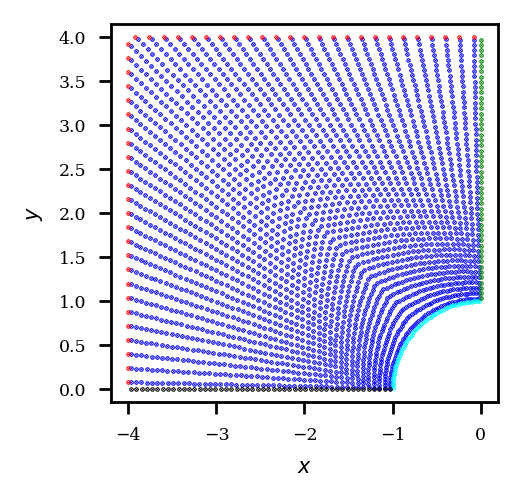

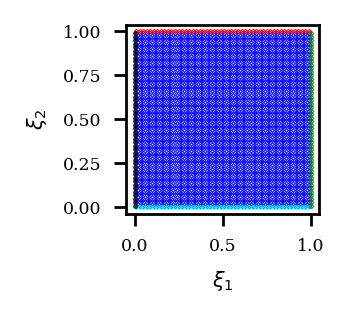

In [33]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
if __name__ == '__main__':
    # Generating points inside the domain using Geometry class
    problem_param = dict()
    model_data = dict()
    realscale = 1.0  # makes the result less sensitive w.r.t the small scale. Results will be given after unscaling.
    problem_param['E'] = 1000  # 135 * 1e-9 N/nm^2
    problem_param['nu'] = 0.3
    problem_param['lengthscale'] = 0.0  # 0.25 * 1e6 nm^2
    problem_param['radInt'] = 1.0  # 1 * 1e3 nm
    problem_param['lenSquare'] = 4.0
    problem_param['P'] = 10.0  # 10 * 1e-12 N/nm^2
    problem_param['scale_factor'] = realscale

    # Domain bounds
    NN_param = dict()
    NN_param['layers'] = [2, 30, 30, 30, 2]
    NN_param['iteration'] = 350
    NN_param['learning_rate'] = 0.5

    myPlate = PlateHoleISO(problem_param['radInt'], problem_param['lenSquare'])

    numElemU = 50
    numElemV = 50
    numGauss = 1

    # Generate the boundary points using Geometry class
    numElemEdge = 50
    numGaussEdge = 1

    xyw_domain, xyw_lefttop, t_lefttop, xyw_inner, xyw_right, xyw_bottom, xi_domain, dxidx_domain, xi_lefttop, xi_inner, xi_right, xi_bottom = \
    gen_data_isodem_plate(problem_param, myPlate, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge)
    
    fig1 = plt.figure(figsize=(2, 2))
    subfig1 = fig1.add_subplot(1, 1, 1)
    subfig1.scatter(xyw_domain[:, 0:1], xyw_domain[:, 1:2], s=0.1, c='blue')
    subfig1.scatter(xyw_inner[:, 0:1], xyw_inner[:, 1:2], s=0.1, c='cyan', zorder=10)
    subfig1.scatter(xyw_right[:, 0:1], xyw_right[:, 1:2], s=0.1, c='green', zorder=10)
    subfig1.scatter(xyw_lefttop[:, 0:1], xyw_lefttop[:, 1:2], s=0.1, c='red', zorder=10)
    subfig1.scatter(xyw_bottom[:, 0:1], xyw_bottom[:, 1:2], s=0.1, c='black', zorder=10)
    subfig1.set_xlabel(r'$x$')
    subfig1.set_ylabel(r'$y$')
    subfig1.axis('equal')
    fig1.savefig(path_save_pic + '/physical_platehole.eps', format='eps')  


    fig2 = plt.figure(figsize=(1.0, 1.0))
    subfig2 = fig2.add_subplot(1, 1, 1)
    subfig2.scatter(xi_domain[:, 0:1], xi_domain[:, 1:2], s=0.1, c='blue')
    subfig2.scatter(xi_inner[:, 0:1], xi_inner[:, 1:2], s=0.1, c='cyan')
    subfig2.scatter(xi_right[:, 0:1], xi_right[:, 1:2], s=0.1, c='green')
    subfig2.scatter(xi_lefttop[:, 0:1], xi_lefttop[:, 1:2], s=0.1, c='red')
    subfig2.scatter(xi_bottom[:, 0:1], xi_bottom[:, 1:2], s=0.1, c='black')
    subfig2.set_xlabel(r'$\xi_1$')
    subfig2.set_ylabel(r'$\xi_2$')
    subfig2.axis('equal')
    fig2.savefig(path_save_pic +  '/isoparam_platehole.eps', format='eps')

    model_data['xy'] = xyw_domain
    model_data['xi'] = xi_domain
    model_data['dxidx'] = dxidx_domain
    model_data['xy_boundary_lefttop'] = xyw_lefttop
    model_data['xi_boundary_lefttop'] = xi_lefttop
    model_data['traction_boundary_lefttop'] = t_lefttop
    model_data['xy_boundary_in'] = xyw_inner
    model_data['xi_boundary_in'] = xi_inner
    model_data['xy_boundary_right'] = xyw_right
    model_data['xi_boundary_right'] = xi_right
    model_data['xy_boundary_bottom'] = xyw_bottom
    model_data['xi_boundary_bottom'] = xi_bottom

    # COMMENT OUT
    # -----------------------------
    mat = ISODEMEnergyModel('elasticity', 2, problem_param['E'], problem_param['nu'], problem_param['lengthscale'])
    
#     # ----------------------------------------------------------------------
#     #               TRANSFER LEARNING APPLIED
#     # ----------------------------------------------------------------------
#     #     Free mlp1 parameters
#     for param in isodem_plate.model.parameters():
#         param.requires_grad = False

#     isodem_plate.model.mlp2 = nn.Sequential(nn.Linear(30, 100),
#                                             nn.Tanh(),
#                                             nn.Linear(100, 100),
#                                             nn.Tanh(),
#                                             nn.Linear(100, 30),
#                                             nn.Tanh())

#     for param in isodem_plate.model.parameters():
#         print(param)

#     isodem_plate.optimizer = torch.optim.LBFGS(isodem_plate.model.mlp2.parameters(), lr=isodem_plate.learning_rate_lbfgs, max_iter=20)


In [34]:

isodem_plate = ISODEMPlate(NN_param['layers'], 'gauss', mat, 2, NN_param, network=False)
print(isodem_plate.model)
# # ----------------------------------------------------------------------
# #                   STEP 3: TRAINING MODEL
# # ----------------------------------------------------------------------
start_time = time.time()
isodem_plate.train_model(model_data, problem_param, None)
end_time = time.time() - start_time
print("End time: %.5f" % end_time)
# -----------------------------


MultiLayerNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=2, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
Iter: 1 Loss: 1.718059387e+02 - L2-error: 8.817329407e+00 - Energy-error: 1.462578931e+01 - Time: 6.503e-01
Iter: 1 Loss: 1.348513794e+02 - L2-error: 7.720626354e+00 - Energy-error: 1.295096155e+01 - Time: 2.990e-01
Iter: 1 Loss: 3.754004288e+01 - L2-error: 3.881979942e+00 - Energy-error: 6.873623397e+00 - Time: 2.761e-01
Iter: 1 Loss: 1.274888515e+01 - L2-error: 2.058095694e+00 - Energy-error: 4.186447729e+00 - Time: 2.743e-01
Iter: 1 Loss: 6.580167294e+00 - L2-error: 1.248737454e+00 - Energy-error: 3.244433740e+00 - Time: 2.699e-01
Iter: 1 Loss: 4.865113735e+00 - L2-error: 9.048686028e-01 - Energy-error: 2.952786422e+00 - Time: 2.861e-01
Iter: 1 Loss: 4.

### Step 6: Post processing; Verify results; Plot convergence

Relative L2 error:  0.0017549676753848106


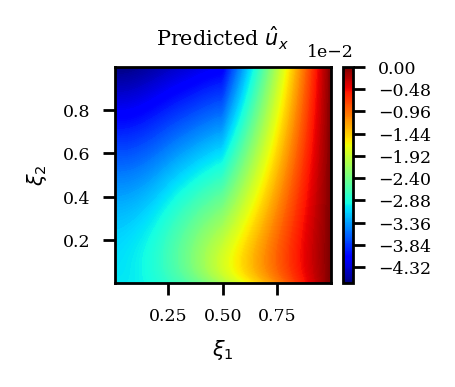

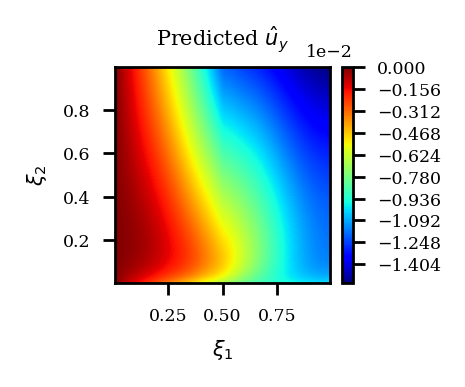

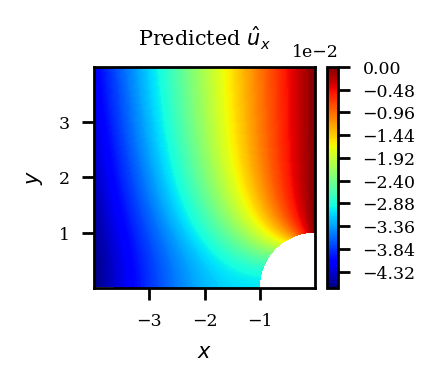

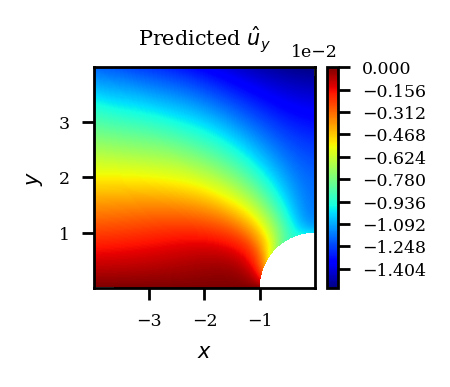

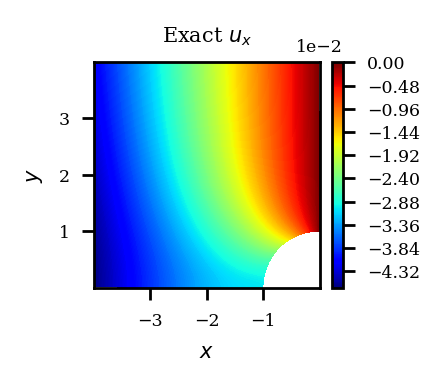

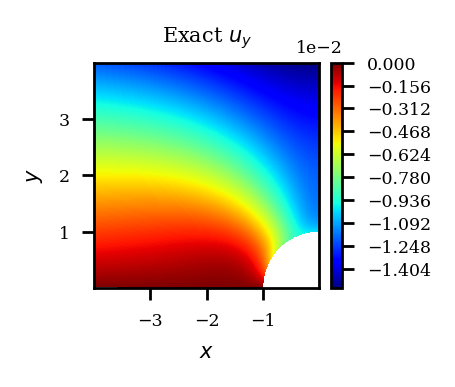

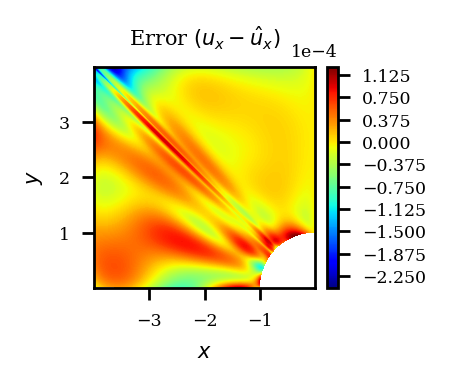

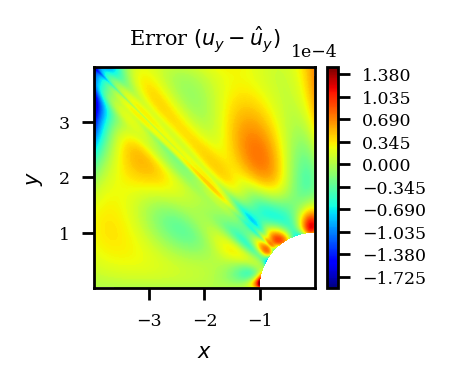

In [35]:
numElemU = 200
numElemV = 200
numGauss = 1
# Generate the boundary points using Geometry class
numElemEdge = 200
numGaussEdge = 1
xyw_domain, xyw_lefttop, t_lefttop, xyw_inner, xyw_right, xyw_bottom, xi_domain, dxidx_domain, xi_lefttop, xi_inner, xi_right, xi_bottom = \
gen_data_isodem_plate(problem_param, myPlate, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge)
plate_x1 = np.resize(xyw_domain[:, 0:1], [numElemU, numElemV])
plate_x2 = np.resize(xyw_domain[:, 1:2], [numElemU, numElemV])
ux_exact, uy_exact = uexact_plate(plate_x1, plate_x2, problem_param)
ux_min=np.min(ux_exact)
ux_max=np.max(ux_exact)
uy_min=np.min(uy_exact)
uy_max=np.max(uy_exact)
levels_ux = np.linspace(ux_min, ux_max, 255)
levels_uy = np.linspace(uy_min, uy_max, 255)
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT ux, uy in REFERENCE DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# xi_tensor = torch.from_numpy(xyw_domain[:, 0:2]).float()
# xi_tensor = xi_tensor.to(dev)
# xi_tensor.requires_grad_(True)
# u_pred_torch = isodem_plate.getU(xi_tensor)
# u_pred = u_pred_torch.detach().cpu().numpy()

isodem_plate_array = [isodem_plate]

for i in range(len(isodem_plate_array)):
    isodem = isodem_plate_array[i]
    xi_tensor = torch.from_numpy(xi_domain).float()
    xi_tensor = xi_tensor.to(dev)
    xi_tensor.requires_grad_(True)
    u_pred_torch = isodem.getU(xi_tensor)
    u_pred = u_pred_torch.detach().cpu().numpy()

    plate_xi1 = np.resize(xi_domain[:, 0:1], [numElemU, numElemV])
    plate_xi2 = np.resize(xi_domain[:, 1:2], [numElemU, numElemV])
    plate_ux  = np.resize(u_pred[:, 0:1], [numElemU, numElemV])
    plate_uy  = np.resize(u_pred[:, 1:2], [numElemU, numElemV])

    # ----------- Plot displacement Ux in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_xi1, plate_xi2, plate_ux, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$\xi_1$')
    ax.set_ylabel(r'$\xi_2$')
    ax.set_title(r"Predicted $\hat{u}_x$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_isoux_platehole.eps', format='eps')

    # ----------- Plot displacement Uy in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_xi1, plate_xi2, plate_uy, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$\xi_1$')
    ax.set_ylabel(r'$\xi_2$')
    ax.set_title(r"Predicted $\hat{u}_y$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_isouy_platehole.eps', format='eps')

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT ux, uy in Physical DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    # ----------- Plot NN displacement Ux in physical domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, plate_ux, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Predicted $\hat{u}_x$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_ux_platehole.eps', format='eps')

    # ----------- Plot NN displacement Uy in physical domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, plate_uy, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Predicted $\hat{u}_y$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_uy_platehole.eps', format='eps')



    plate_x1 = np.resize(xyw_domain[:, 0:1], [numElemU, numElemV])
    plate_x2 = np.resize(xyw_domain[:, 1:2], [numElemU, numElemV])
    # ----------- Plot exact displacement Ux in physical domain  -------------------------------------------

    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, ux_exact, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Exact $u_x$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_ux-exact_platehole.eps', format='eps')

    # ----------- Plot exact displacement Uy in physical domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, uy_exact, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Exact $u_y$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_uy-exact_platehole.eps', format='eps')

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT errors in Physical DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # ----------- Plot error displacement Ux in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, ux_exact - plate_ux, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Error $(u_x - \hat{u}_x)$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_ux-error_platehole.eps', format='eps')

    # ----------- Plot error displacement Uy in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, uy_exact - plate_uy, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Error $(u_y - \hat{u}_y)$")
    fig.tight_layout()
    ax.set_aspect('equal')
    
    
    
    # fig.tight_layout()
    fig.savefig(path_save_pic + '/isoparam_isodem_uy-error_platehole.eps', format='eps')

    error_Ux = ux_exact - plate_ux
    error_Uy = uy_exact - plate_uy
    err = error_Ux**2 + error_Uy**2
    err_norm = err.sum()
    ex = ux_exact**2 + uy_exact**2
    ex_norm = ex.sum()
    error_u = np.sqrt(err_norm/ex_norm)
    print("Relative L2 error: ", error_u)

# DEM

In [36]:
class DEMPlate:
    # Instance attributes
    def __init__(self, layers, numIntType, energy, dim, nn_param, network=False):
        # self.data = data
        if network == False:
            self.model = MultiLayerNet(layers)
#             self.model = Siren(in_features=2, out_features=2, hidden_features=30, hidden_layers=3, outermost_linear=True, first_omega_0=10, hidden_omega_0=10.)
#             self.model.cuda()
        else:
            state_dict = torch.load('isodem_elasticity_beam2d.pth', map_location=dev)
            print(state_dict.keys())
            # Try this
            self.model = MultiLayerNet(layers)
            # This will throw an error because the tensor sizes are wrong!
            self.model.load_state_dict(state_dict)
            self.model = self.model.to(dev)
        #         self.intLoss = IntegrationLoss(numIntType, dim)
        self.energy = energy
        # self.post = PostProcessing(energy, dim)
        self.dim = dim
        
        self.iteration_lbfgs = nn_param['iteration']
        self.learning_rate_lbfgs = nn_param['learning_rate']
        self.optimizer_adam = torch.optim.Adam(params=self.model.parameters())              
#         optimizer = torch.optim.LBFGS(self.model.parameters(), lr=learning_rate_lbfgs, max_iter=20, max_eval=50000, history_size=50, line_search_fn='strong_wolfe')
        self.optimizer = torch.optim.LBFGS(self.model.parameters(), lr=self.learning_rate_lbfgs, max_iter=20)
    
        self.lossArray = []
        self.valLossArray = []
        self.l2errorArray = []
        self.enerrorArray = []

    def train_model(self, data, problem_param, xy_validation):
        # ---------- training data ---------------#
        xy_domain = data['xy']

        xi_domain = data['xi']

        dxidx_domain = data['dxidx']

        xy_boundary_lefttop = data['xy_boundary_lefttop']

        xi_boundary_lefttop = data['xi_boundary_lefttop']

        traction_boundary_lefttop = data['traction_boundary_lefttop']

        xy_boundary_in = data['xy_boundary_in']

        xi_boundary_in = data['xi_boundary_in']

        xy_boundary_right = data['xy_boundary_right']

        xi_boundary_right = data['xi_boundary_right']

        xy_boundary_bottom = data['xy_boundary_bottom']

        xi_boundary_bottom = data['xi_boundary_bottom']

        xy = torch.from_numpy(xy_domain[:, 0:2]).float()
        xy = xy.to(dev)
        xy.requires_grad_(True)
        weightXY = torch.from_numpy(xy_domain[:, 2]).float()
        weightXY = weightXY.to(dev)

        xi = torch.from_numpy(xi_domain[:, 0:2]).float()
        xi = xi.to(dev)
        xi.requires_grad_(True)

        dxidx = torch.from_numpy(dxidx_domain[:, 0:4]).float()
        dxidx = dxidx.to(dev)

        xyLeftTop = torch.from_numpy(xy_boundary_lefttop[:, 0:2]).float()
        xyLeftTop = xyLeftTop.to(dev)
        xyLeftTop.requires_grad_(True)
        weightXYBoundLT = torch.from_numpy(xy_boundary_lefttop[:, 2:3]).float()
        weightXYBoundLT = weightXYBoundLT.to(dev)

        xiLeftTop = torch.from_numpy(xi_boundary_lefttop[:, 0:2]).float()
        xiLeftTop = xiLeftTop.to(dev)
        xiLeftTop.requires_grad_(True)

        xyIn = torch.from_numpy(xy_boundary_in[:, 0:2]).float()
        xyIn = xyIn.to(dev)
        xyIn.requires_grad_(True)
        xiIn = torch.from_numpy(xi_boundary_in[:, 0:2]).float()
        xiIn = xiIn.to(dev)
        xiIn.requires_grad_(True)

        xyRight = torch.from_numpy(xy_boundary_right[:, 0:2]).float()
        xyRight = xyRight.to(dev)
        xyRight.requires_grad_(True)
        xiRight = torch.from_numpy(xi_boundary_right[:, 0:2]).float()
        xiRight = xiRight.to(dev)
        xiRight.requires_grad_(True)

        xyBottom = torch.from_numpy(xy_boundary_bottom[:, 0:2]).float()
        xyBottom = xyBottom.to(dev)
        xyBottom.requires_grad_(True)
        xiBottom = torch.from_numpy(xi_boundary_bottom[:, 0:2]).float()
        xiBottom = xiBottom.to(dev)
        xiBottom.requires_grad_(True)

        traction_boundary_lefttop = torch.from_numpy(traction_boundary_lefttop).float().to(dev)
        
        # ----------------- end ---------------------- #

        start_time = time.time()
        energy_loss_array = []
        boundary_loss_array = []
        # loss_array = []
        iteration1 = 2000
        
        for t in range(self.iteration_lbfgs):
            # Zero gradients, perform a backward pass, and update the weights.
            def closure():
                it_time = time.time()
                self.optimizer.zero_grad()
                # ------------------------------------------------------------------------------------
                u_pred = self.getU(xy)
                u_pred.double()
                strain_energy, sigma_pred, eps_pred = self.energy.linear_elasticity_normal(u_pred, xy)
                U = torch.sum(strain_energy * weightXY)

                u_boundary_lefttop_pred = self.getU(xyLeftTop)
                trac_lefttop = torch.bmm(u_boundary_lefttop_pred.unsqueeze(1), traction_boundary_lefttop.unsqueeze(2))
                W1 = torch.sum(trac_lefttop[:, 0] * weightXYBoundLT)

                loss = U - W1
                # --------------------------- #
                uv_nn = u_pred.detach().cpu().numpy()
                xy_coordinates = xy.detach().cpu().numpy()
                u_exact, v_exact = uexact_plate(xy_coordinates[:, 0:1], xy_coordinates[:, 1:2], problem_param)
                uv_exact = np.concatenate((u_exact, v_exact), axis=1)
                l2error = np.linalg.norm(uv_nn - uv_exact)/np.linalg.norm(uv_exact)
                
                sigma_nn = sigma_pred.detach().cpu().numpy()
                eps_nn = eps_pred.detach().cpu().numpy()
                sigma_exact = sigma_exact_plate(xy_domain[:, 0:1], xy_domain[:, 1:2], problem_param)
                eps_exact = eps_exact_plate(self.energy.mu, self.energy.lam, sigma_exact)
                energy_norm_nu = 0.5 * np.matmul(np.reshape((eps_exact - eps_nn), (len(xy), 1, 3)), np.reshape((sigma_exact - sigma_nn), (len(xy), 3, 1 )))
                energy_norm_de = 0.5 * np.matmul(np.reshape(eps_exact, (len(xy), 1, 3)), np.reshape(sigma_exact, (len(xy), 3, 1 )))
                e_error = np.sqrt(np.sum(energy_norm_nu * xy_domain[:, 2:3]) / np.sum(energy_norm_de * xy_domain[:, 2:3]))
                
                loss.backward()
                print('Iter: %d Loss: %.9e - L2-error: %.9e - Energy-error: %.9e - Time: %.3e' % (t + 1, loss.item(), l2error, e_error, time.time() - it_time))
                # energy_loss_array.append(energy_loss.data)
                # boundary_loss_array.append(boundary_loss.data)
                self.l2errorArray.append(l2error)
                self.enerrorArray.append(e_error)
                self.lossArray.append(loss.data)
                return loss

            self.optimizer.step(closure)

        elapsed = time.time() - start_time
        print('Training time: %.4f' % elapsed)

    def getU(self, xy):
        u = self.model(xy)
        u1 = (xy[:, 0:1]) * u[:, 0:1]
        u2 = (xy[:, 1:2]) * u[:, 1:2]
        u_pred = torch.cat((u1, u2), 1)
        return u_pred
    # --------------------------------------------------------------------------------
    # method: loss sum for the energy part
    # --------------------------------------------------------------------------------
    @staticmethod
    def loss_sum(tinput):
        return torch.sum(tinput) / tinput.data.nelement()

    def mse_loss(self, tinput, target):
        return torch.sum((tinput - target) ** 2) / tinput.data.nelement()

    # --------------------------------------------------------------------------------
    # purpose: loss square sum for the boundary part
    # --------------------------------------------------------------------------------
    @staticmethod
    def loss_squared_sum(tinput, target):
        row, column = tinput.shape
        loss = 0
        for j in range(column):
            loss += torch.sum((tinput[:, j] - target[:, j]) ** 2) / tinput[:, j].data.nelement()
        return loss

In [37]:
dem_plate = DEMPlate(NN_param['layers'], 'gauss', mat, 2, NN_param, network=False)
print(dem_plate.model)
# # ----------------------------------------------------------------------
# #                   STEP 3: TRAINING MODEL
# # ----------------------------------------------------------------------
start_time = time.time()
dem_plate.train_model(model_data, problem_param, None)
end_time = time.time() - start_time
print("End time: %.5f" % end_time)
# -----------------------------


MultiLayerNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=2, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
Iter: 1 Loss: 7.265162109e+03 - L2-error: 6.462250519e+01 - Energy-error: 8.996429518e+01 - Time: 2.574e-01
Iter: 1 Loss: 6.070411133e+03 - L2-error: 5.843121719e+01 - Energy-error: 8.210082460e+01 - Time: 2.619e-01
Iter: 1 Loss: 3.223039551e+03 - L2-error: 3.835559845e+01 - Energy-error: 5.913696845e+01 - Time: 2.780e-01
Iter: 1 Loss: 1.984438965e+03 - L2-error: 2.512508965e+01 - Energy-error: 4.566868032e+01 - Time: 2.790e-01
Iter: 1 Loss: 1.260440063e+03 - L2-error: 1.551695919e+01 - Energy-error: 3.576292677e+01 - Time: 2.560e-01
Iter: 1 Loss: 7.530976562e+02 - L2-error: 8.889619827e+00 - Energy-error: 2.715140088e+01 - Time: 2.564e-01
Iter: 1 Loss: 4.

# With different NN architecture

In [38]:
NN_param = dict()
NN_param['layers'] = [2, 30, 2]
NN_param['iteration'] = 350
NN_param['learning_rate'] = 0.5


isodem_plate_n1 = ISODEMPlate(NN_param['layers'], 'gauss', mat, 2, NN_param, network=False)
print(isodem_plate_n1.model)
# # ----------------------------------------------------------------------
# #                   STEP 3: TRAINING MODEL
# # ----------------------------------------------------------------------
start_time = time.time()
isodem_plate_n1.train_model(model_data, problem_param, None)
end_time = time.time() - start_time
print("End time: %.5f" % end_time)
# -----------------------------



MultiLayerNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=2, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
Iter: 1 Loss: 4.971183777e+02 - L2-error: 1.835099792e+01 - Energy-error: 2.740932422e+01 - Time: 2.608e-01
Iter: 1 Loss: 3.747351074e+02 - L2-error: 1.585566807e+01 - Energy-error: 2.384756226e+01 - Time: 2.500e-01
Iter: 1 Loss: 1.087999420e+02 - L2-error: 8.617159843e+00 - Energy-error: 1.303628446e+01 - Time: 2.508e-01
Iter: 1 Loss: 3.257539368e+01 - L2-error: 4.534713745e+00 - Energy-error: 7.351782998e+00 - Time: 2.512e-01
Iter: 1 Loss: 1.081653976e+01 - L2-error: 2.314838171e+00 - Energy-error: 4.447693550e+00 - Time: 2.503e-01
Iter: 1 Loss: 4.375959396e+00 - L2-error: 1.205679536e+00 - Energy-error: 3.041784748e+00 - Time: 2.502e-01
Iter: 1 Loss: 2.285622358e+00 - L2-error: 9.696962833e-01 - Energy-error: 2.372605665e+00 - Time: 2.552e-01
Iter: 1 Loss: 1.455031633e+0

In [39]:
NN_param = dict()
NN_param['layers'] = [2, 30, 30, 2]
NN_param['iteration'] = 350
NN_param['learning_rate'] = 0.5


isodem_plate_n2 = ISODEMPlate(NN_param['layers'], 'gauss', mat, 2, NN_param, network=False)
print(isodem_plate_n2.model)
# # ----------------------------------------------------------------------
# #                   STEP 3: TRAINING MODEL
# # ----------------------------------------------------------------------
start_time = time.time()
isodem_plate_n2.train_model(model_data, problem_param, None)
end_time = time.time() - start_time
print("End time: %.5f" % end_time)
# -----------------------------


MultiLayerNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=2, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
Iter: 1 Loss: 1.166295319e+02 - L2-error: 8.621430397e+00 - Energy-error: 1.332819185e+01 - Time: 2.519e-01
Iter: 1 Loss: 8.227925110e+01 - L2-error: 7.047782898e+00 - Energy-error: 1.122556502e+01 - Time: 2.540e-01
Iter: 1 Loss: 2.765778732e+01 - L2-error: 3.904788256e+00 - Energy-error: 6.490687165e+00 - Time: 2.532e-01
Iter: 1 Loss: 9.445211411e+00 - L2-error: 2.278919697e+00 - Energy-error: 3.735127453e+00 - Time: 2.506e-01
Iter: 1 Loss: 3.693199635e+00 - L2-error: 1.494889975e+00 - Energy-error: 2.313230353e+00 - Time: 2.539e-01
Iter: 1 Loss: 1.961652756e+00 - L2-error: 1.192447901e+00 - Energy-error: 1.752514862e+00 - Time: 2.551e-01
Iter: 1 Loss: 1.433990240e+00 - L2-error: 1.114027858e+00 - Energy-error: 1.

In [40]:
NN_param = dict()
NN_param['layers'] = [2, 30, 30, 30, 30, 2]
NN_param['iteration'] = 350
NN_param['learning_rate'] = 0.5

isodem_plate_n3 = ISODEMPlate(NN_param['layers'], 'gauss', mat, 2, NN_param, network=False)
print(isodem_plate_n3.model)
# # ----------------------------------------------------------------------
# #                   STEP 3: TRAINING MODEL
# # ----------------------------------------------------------------------
start_time = time.time()
isodem_plate_n3.train_model(model_data, problem_param, None)
end_time = time.time() - start_time
print("End time: %.5f" % end_time)
# ---------------------------------------------------------------------------------------

MultiLayerNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=2, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
Iter: 1 Loss: 2.819179382e+02 - L2-error: 7.506630898e+00 - Energy-error: 2.188153358e+01 - Time: 2.683e-01
Iter: 1 Loss: 2.348404388e+02 - L2-error: 6.660911560e+00 - Energy-error: 2.008984709e+01 - Time: 2.624e-01
Iter: 1 Loss: 8.641865540e+01 - L2-error: 3.111721277e+00 - Energy-error: 1.255225848e+01 - Time: 2.658e-01
Iter: 1 Loss: 4.334809494e+01 - L2-error: 1.733937263e+00 - Energy-error: 8.838335595e+00 - Time: 2.619e-01
Iter: 1 Loss: 3.034031296e+01 - L2-error: 1.640339375e+00 - Energy-error: 7.102556040e+00 - Time: 2.534e-01
Iter: 1 Loss: 2.487102318e+01 - L2-error: 1.768364668e+00 - Ener

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


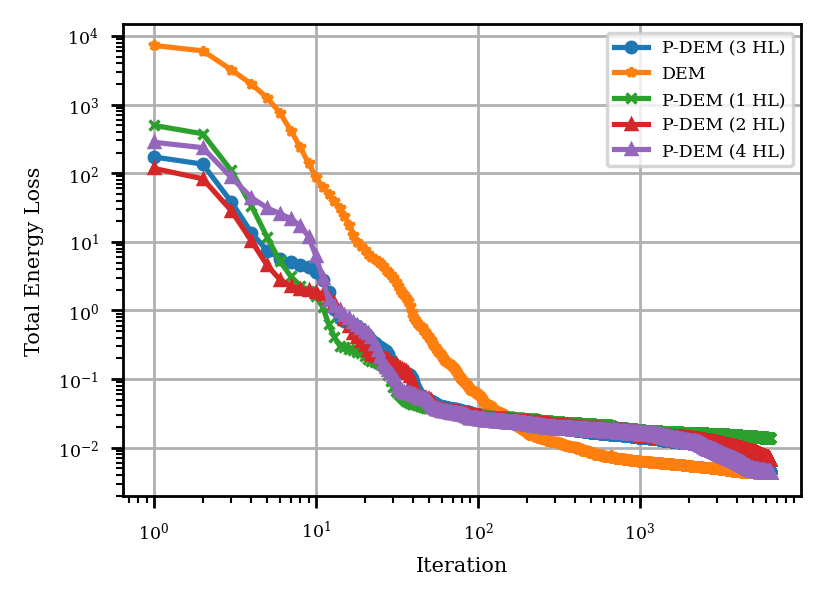

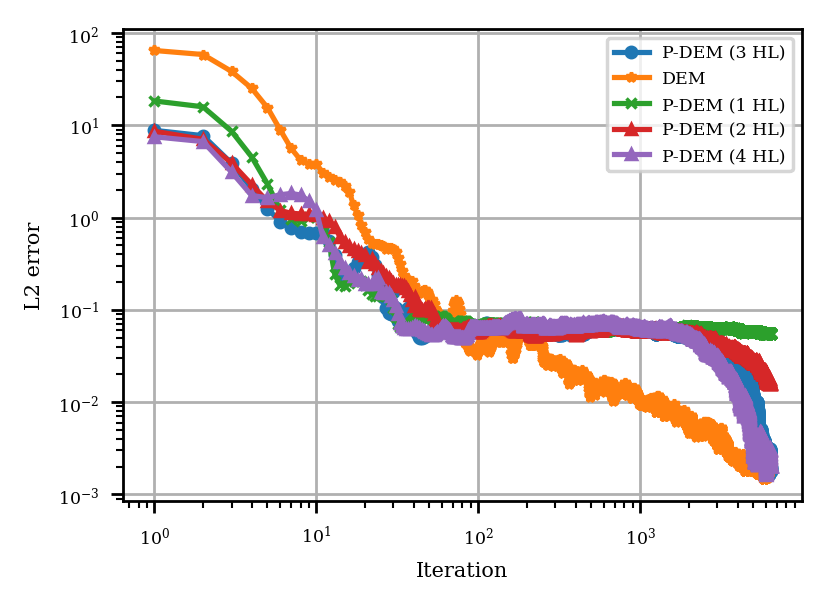

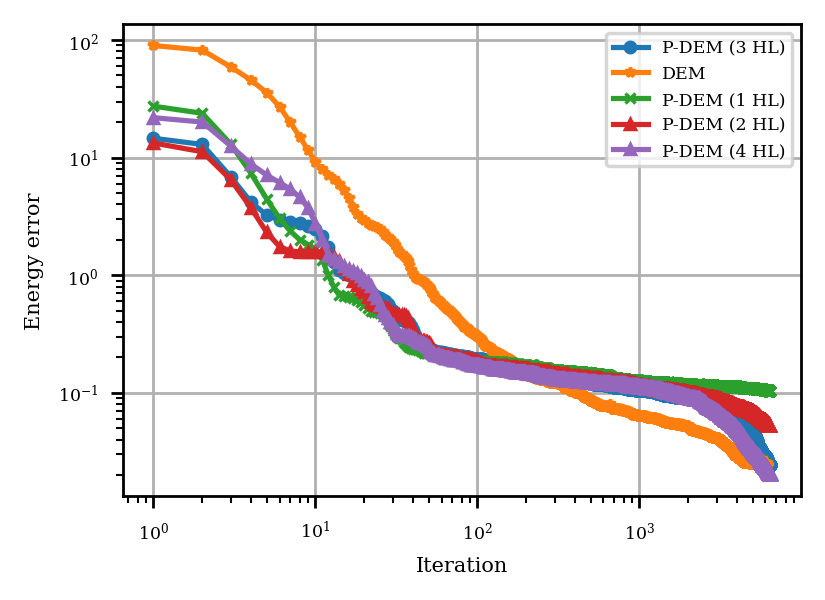

In [41]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT TRAINING LOSS CONVERGENCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
iter_step1 = np.arange(1, len(isodem_plate.lossArray) + 1)
lossArray1 = np.zeros(len(isodem_plate.lossArray))
l2errorArray1 = isodem_plate.l2errorArray
enerrorArray1 = isodem_plate.enerrorArray

iter_step_n1 = np.arange(1, len(isodem_plate_n1.lossArray) + 1)
lossArray_n1 = np.zeros(len(isodem_plate_n1.lossArray))
l2errorArray_n1 = isodem_plate_n1.l2errorArray
enerrorArray_n1 = isodem_plate_n1.enerrorArray

iter_step_n2 = np.arange(1, len(isodem_plate_n2.lossArray) + 1)
lossArray_n2 = np.zeros(len(isodem_plate_n2.lossArray))
l2errorArray_n2 = isodem_plate_n2.l2errorArray
enerrorArray_n2 = isodem_plate_n2.enerrorArray

iter_step_n3 = np.arange(1, len(isodem_plate_n3.lossArray) + 1)
lossArray_n3 = np.zeros(len(isodem_plate_n3.lossArray))
l2errorArray_n3 = isodem_plate_n3.l2errorArray
enerrorArray_n3 = isodem_plate_n3.enerrorArray

iter_step2 = np.arange(1, len(dem_plate.lossArray) + 1)
lossArray2 = np.zeros(len(dem_plate.lossArray))
l2errorArray2 = dem_plate.l2errorArray
enerrorArray2 = dem_plate.enerrorArray
 # ------------
# without transfer learning + isodem
i = 0
for loss in isodem_plate.lossArray:
    lossArray1[i] = loss.data.cpu().numpy()
    i = i + 1

i = 0
for loss in isodem_plate_n1.lossArray:
    lossArray_n1[i] = loss.data.cpu().numpy()
    i = i + 1

i = 0
for loss in isodem_plate_n2.lossArray:
    lossArray_n2[i] = loss.data.cpu().numpy()
    i = i + 1

i = 0
for loss in isodem_plate_n3.lossArray:
    lossArray_n3[i] = loss.data.cpu().numpy()
    i = i + 1
    
# With transfer learning + isodem
i = 0
for loss in dem_plate.lossArray:
    lossArray2[i] = loss.data.cpu().numpy()
    i = i + 1

    
posValue = 0.84888
t1 = lossArray1[:] + posValue
t2 = lossArray2[:] + posValue
t3 = lossArray_n1[:] + posValue
t4 = lossArray_n2[:] + posValue
t5 = lossArray_n3[:] + posValue

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))
loss_plt1, = ax.loglog(iter_step1[:], t1, '-o', label='P-DEM (3 HL)', linewidth=1.5, markersize=3)
loss_plt2, = ax.loglog(iter_step2[:], t2, '-*', label='DEM', linewidth=1.5, markersize=3)
loss_plt3, = ax.loglog(iter_step_n1[:], t3,'-x' ,label='P-DEM (1 HL)', linewidth=1.5, markersize=3)
loss_plt4, = ax.loglog(iter_step_n2[:], t4, '-^' , label='P-DEM (2 HL)', linewidth=1.5, markersize=3)

loss_plt5, = ax.loglog(iter_step_n3[:], t5, '-^' , label='P-DEM (4 HL)', linewidth=1.5, markersize=3)

# plt2,     = plt.semilogx(iter_step, valLossArray, label='L-BFGS', linewidth=2)
ax.legend(handles=[loss_plt1, loss_plt2, loss_plt3, loss_plt4, loss_plt5])
ax.grid(True)
ax.set_xlabel('Iteration')
ax.set_ylabel('Total Energy Loss')

fig.savefig(path_save_pic + '/isoparam_lossconvergence_cylinder.eps', format='eps')

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))
l2error_plt1, = ax.loglog(iter_step1[:], l2errorArray1, '-o', label='P-DEM (3 HL)', linewidth=1.5, markersize=3)
l2error_plt2, = ax.loglog(iter_step2[:], l2errorArray2, '-*', label='DEM', linewidth=1.5, markersize=3)
l2error_plt3, = ax.loglog(iter_step_n1[:], l2errorArray_n1, '-x',  label='P-DEM (1 HL)', linewidth=1.5, markersize=3)
l2error_plt4, = ax.loglog(iter_step_n2[:], l2errorArray_n2, '-^', label='P-DEM (2 HL)', linewidth=1.5, markersize=3)

l2error_plt5, = ax.loglog(iter_step_n3[:], l2errorArray_n3, '-^', label='P-DEM (4 HL)', linewidth=1.5, markersize=3)

# plt2,     = plt.semilogx(iter_step, valLossArray, label='L-BFGS', linewidth=2)
ax.legend(handles=[l2error_plt1, l2error_plt2, l2error_plt3, l2error_plt4, l2error_plt5])
ax.grid(True)
ax.set_xlabel('Iteration')
ax.set_ylabel('L2 error')
fig.savefig(path_save_pic + '/isoparam_l2error_cylinder.eps', format='eps')

# PLOTING Energy enorm
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))
eerror_plt1, = ax.loglog(iter_step1[:], enerrorArray1, '-o', label='P-DEM (3 HL)', linewidth=1.5, markersize=3)
eerror_plt2, = ax.loglog(iter_step2[:], enerrorArray2, '-*', label='DEM', linewidth=1.5, markersize=3)
eerror_plt3, = ax.loglog(iter_step_n1[:], enerrorArray_n1, '-x',  label='P-DEM (1 HL)', linewidth=1.5, markersize=3)
eerror_plt4, = ax.loglog(iter_step_n2[:], enerrorArray_n2, '-^', label='P-DEM (2 HL)', linewidth=1.5, markersize=3)
eerror_plt5, = ax.loglog(iter_step_n3[:], enerrorArray_n3, '-^', label='P-DEM (4 HL)', linewidth=1.5, markersize=3)

ax.legend(handles=[eerror_plt1, eerror_plt2, eerror_plt3, eerror_plt4, eerror_plt5])
ax.grid(True)
ax.set_xlabel('Iteration')
ax.set_ylabel('Energy error')
fig.savefig(path_save_pic + '/isoparam_enererror_cylinder.eps', format='eps')

plt.show()

## Step 6: Plot results

Relative L2 error:  0.001752671400049561
Relative energy error (integration):  0.043349184599257275
Relative L2 error:  0.05502299186745728
Relative energy error (integration):  0.1054595178962006


/home/minh/anaconda2/envs/dem/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Relative L2 error:  0.016143431165374807
Relative energy error (integration):  0.05789912945673101
Relative L2 error:  0.0020301047176307374
Relative energy error (integration):  0.04437976669063375
Relative L2 error:  0.0016027775371158899
Relative energy error (integration):  0.02654865935510435


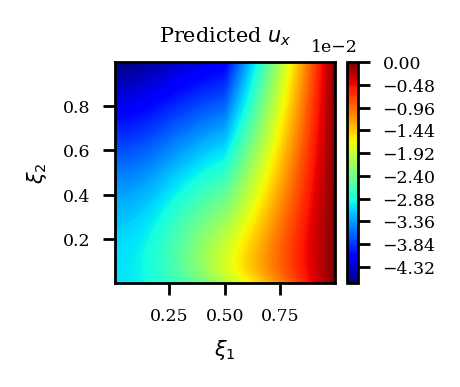

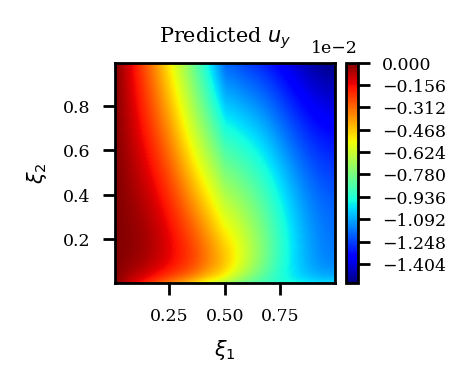

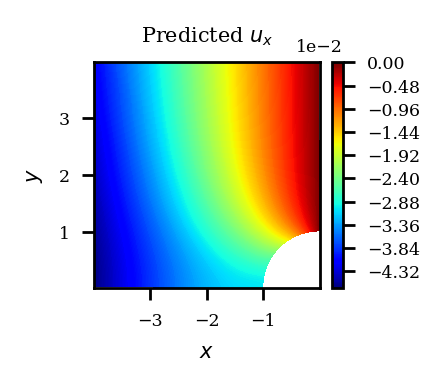

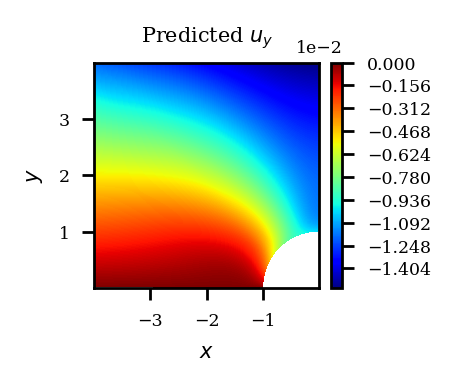

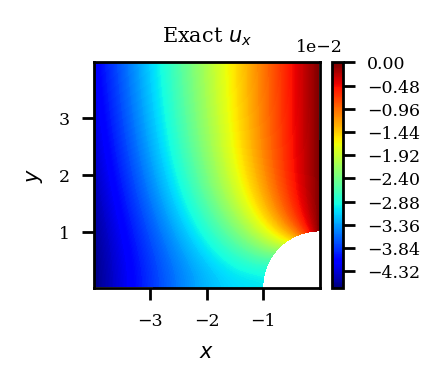

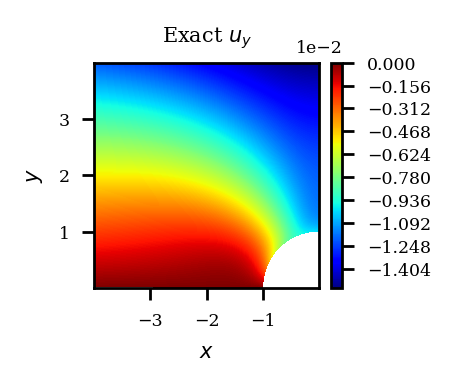

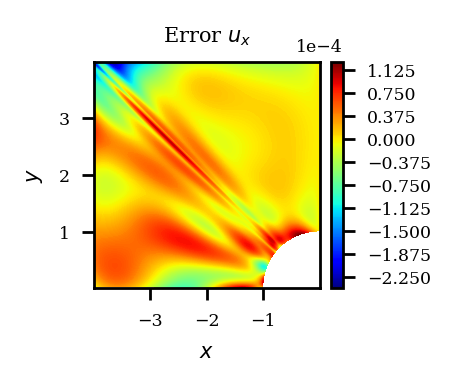

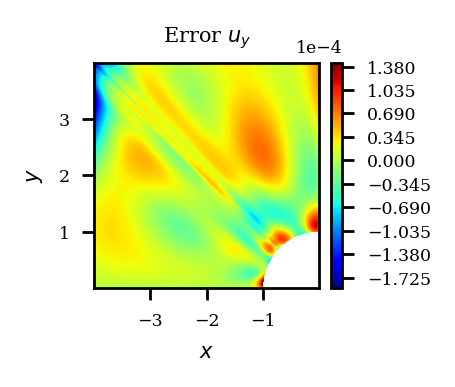

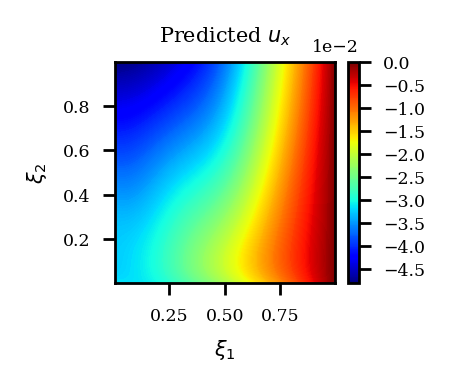

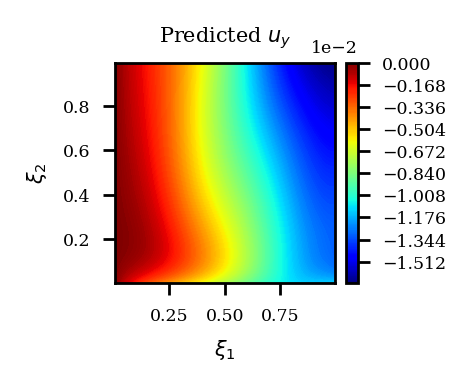

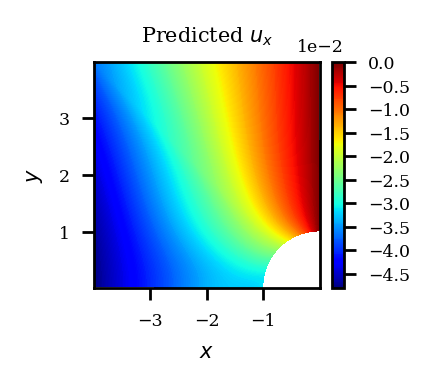

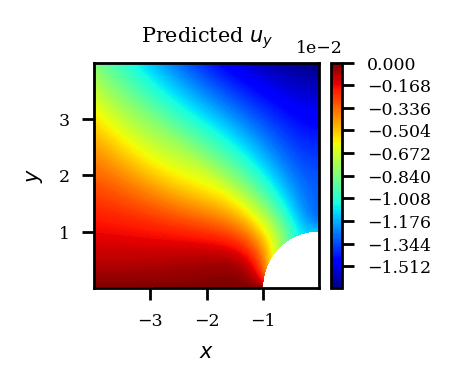

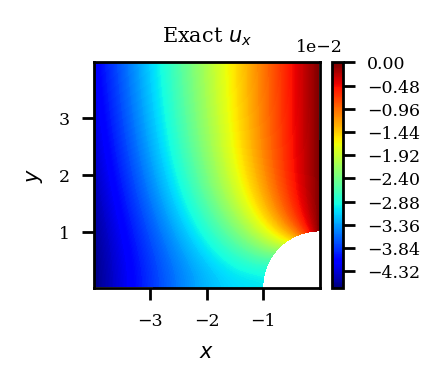

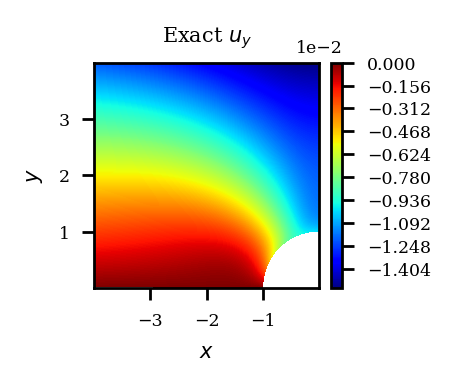

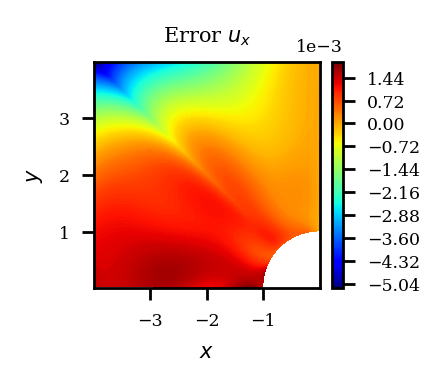

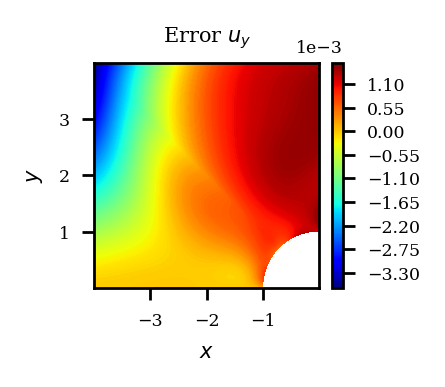

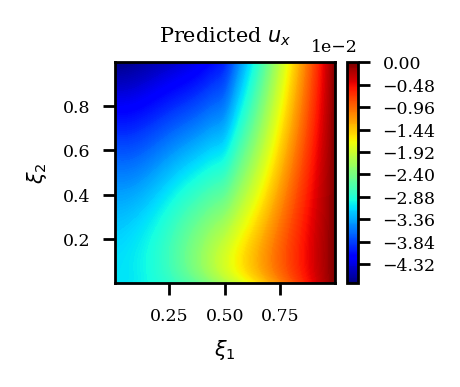

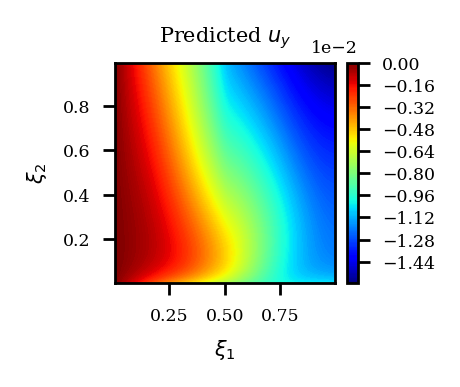

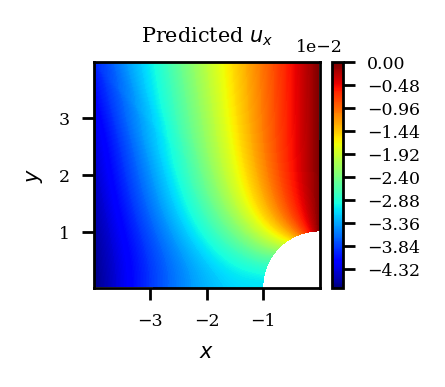

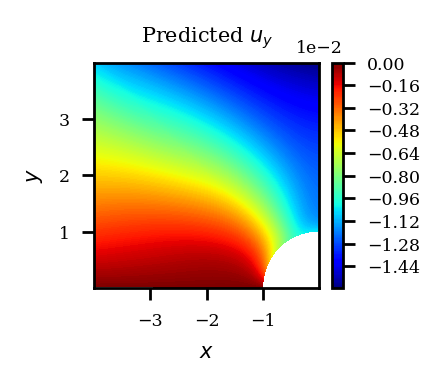

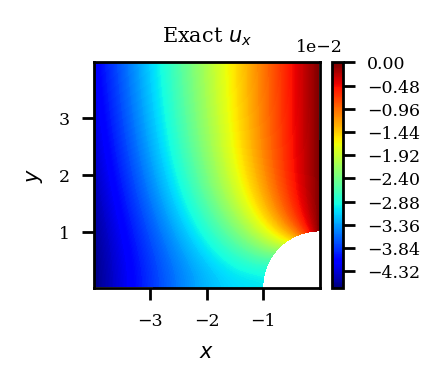

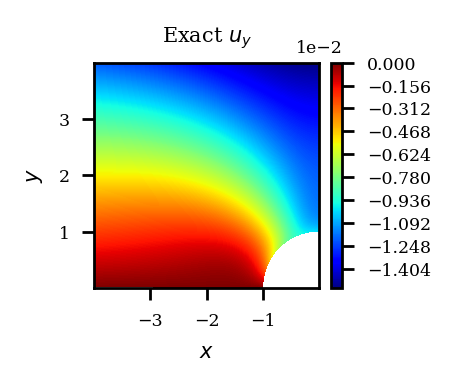

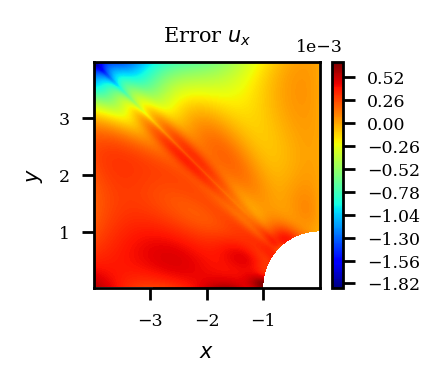

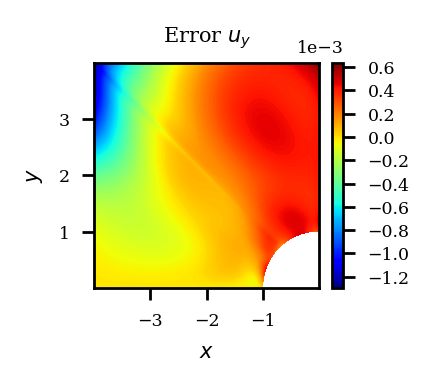

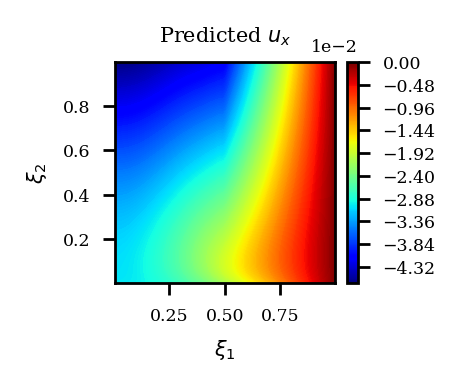

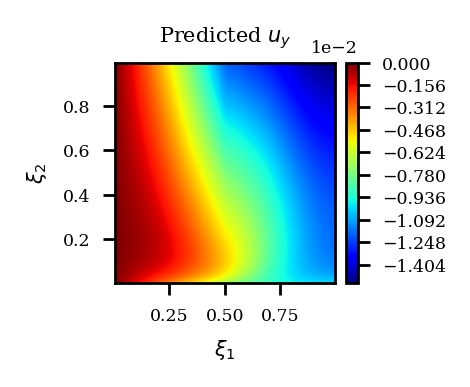

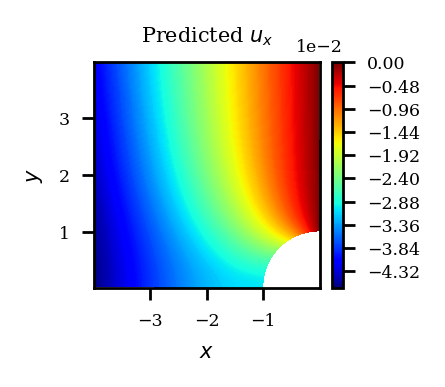

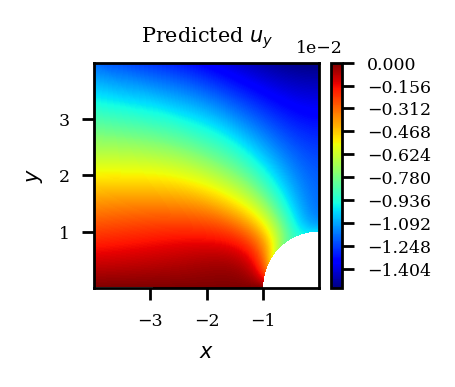

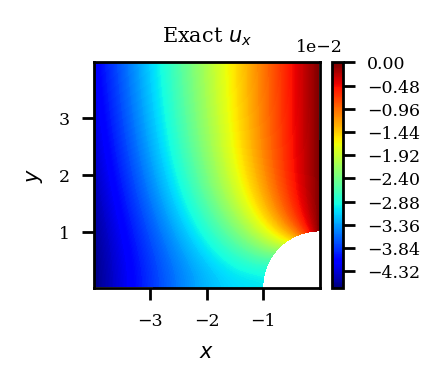

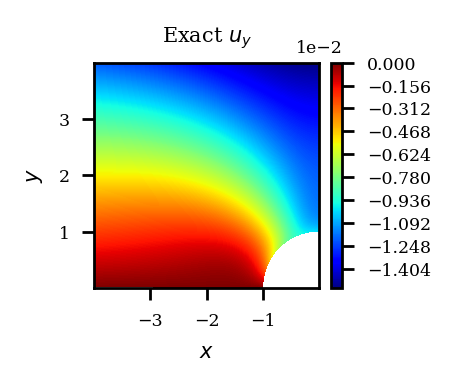

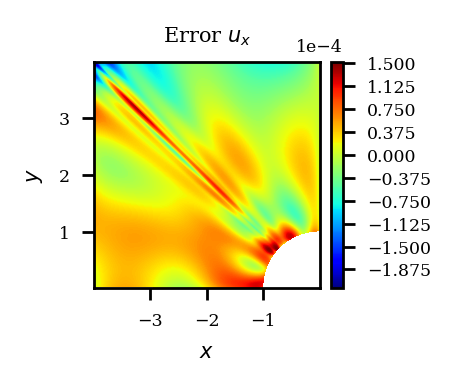

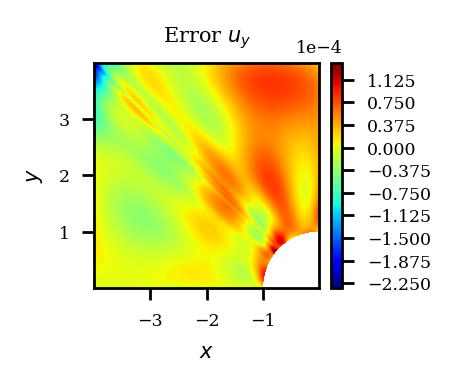

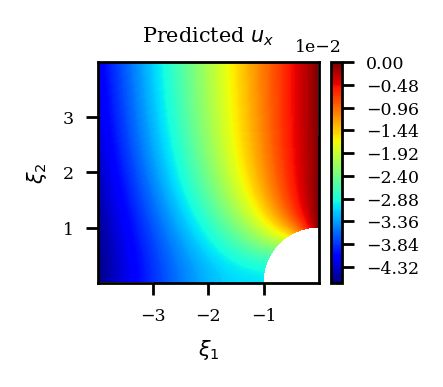

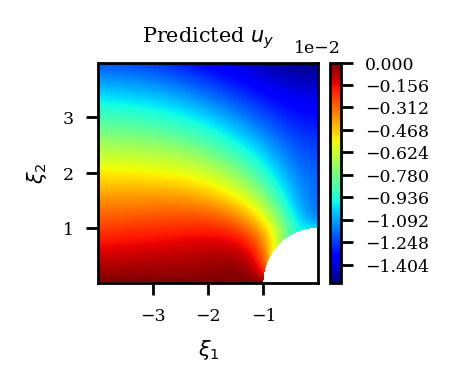

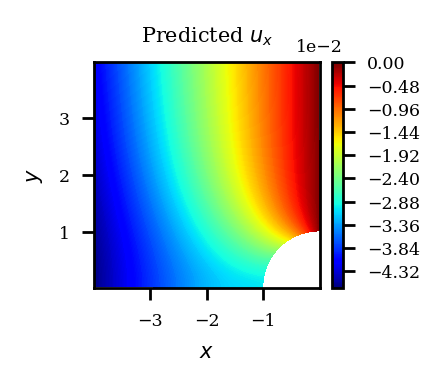

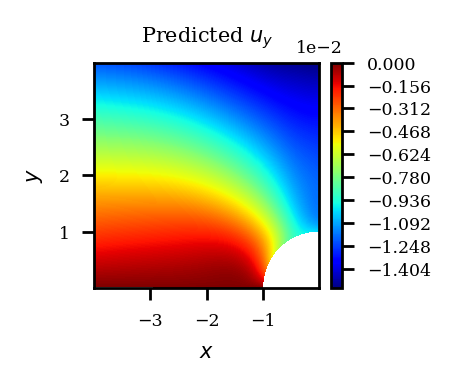

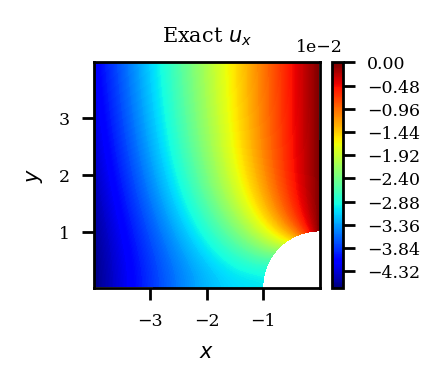

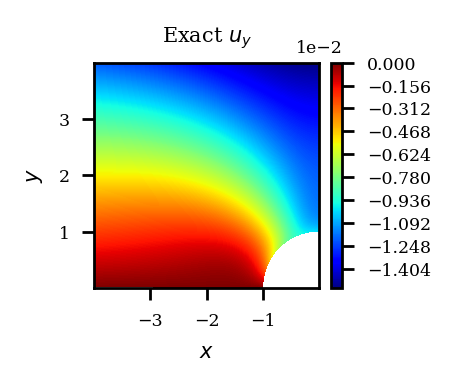

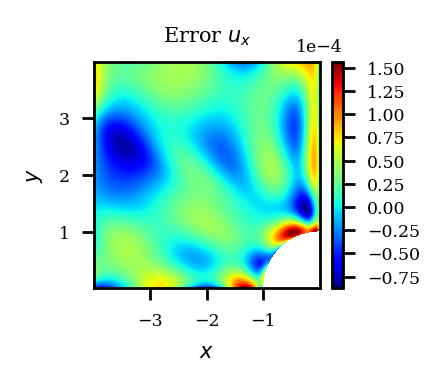

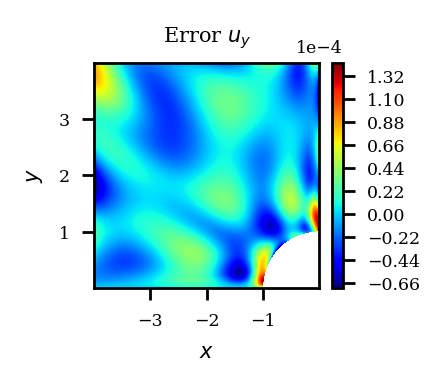

In [42]:
numElemU = 150
numElemV = 150
numGauss = 1
# Generate the boundary points using Geometry class
numElemEdge = 150
numGaussEdge = 1
xyw_domain, xyw_lefttop, t_lefttop, xyw_inner, xyw_right, xyw_bottom, xi_domain, dxidx_domain, xi_lefttop, xi_inner, xi_right, xi_bottom = \
gen_data_isodem_plate(problem_param, myPlate, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge)
plate_x1 = np.resize(xyw_domain[:, 0:1], [numElemU, numElemV])
plate_x2 = np.resize(xyw_domain[:, 1:2], [numElemU, numElemV])
ux_exact, uy_exact = uexact_plate(plate_x1, plate_x2, problem_param)
ux_min=np.min(ux_exact)
ux_max=np.max(ux_exact)
uy_min=np.min(uy_exact)
uy_max=np.max(uy_exact)
levels_ux = np.linspace(ux_min, ux_max, 255)
levels_uy = np.linspace(uy_min, uy_max, 255)

model_data['xy'] = xyw_domain
model_data['xi'] = xi_domain
XY_tensor = torch.from_numpy(xyw_domain[:, 0:2]).float()
XY_tensor = XY_tensor.to(dev)
XY_tensor.requires_grad_(True)

xi_tensor = torch.from_numpy(xi_domain[:, 0:2]).float()
xi_tensor = xi_tensor.to(dev)
xi_tensor.requires_grad_(True)

model_data['dxidx'] = dxidx_domain
dxidx_tensor = torch.from_numpy(dxidx_domain[:, 0:4]).float()
dxidx_tensor = dxidx_tensor.to(dev)
dxidx_tensor.requires_grad_(True)

isodem_plate_array = [isodem_plate, isodem_plate_n1, isodem_plate_n2, isodem_plate_n3]

for i in range(len(isodem_plate_array)):
    isodem = isodem_plate_array[i]
    u_pred_torch = isodem.getU(xi_tensor)
    u_pred = u_pred_torch.detach().cpu().numpy()

    plate_xi1 = np.resize(xi_domain[:, 0:1], [numElemU, numElemV])
    plate_xi2 = np.resize(xi_domain[:, 1:2], [numElemU, numElemV])
    plate_ux  = np.resize(u_pred[:, 0:1], [numElemU, numElemV])
    plate_uy  = np.resize(u_pred[:, 1:2], [numElemU, numElemV])

    # ----------- Plot displacement Ux in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_xi1, plate_xi2, plate_ux, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$\xi_1$')
    ax.set_ylabel(r'$\xi_2$')
    ax.set_title(r"Predicted $u_x$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_isoux_platehole.eps', format='eps')

    # ----------- Plot displacement Uy in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_xi1, plate_xi2, plate_uy, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$\xi_1$')
    ax.set_ylabel(r'$\xi_2$')
    ax.set_title(r"Predicted $u_y$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_isouy_platehole.eps', format='eps')

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT ux, uy in Physical DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    # ----------- Plot NN displacement Ux in physical domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, plate_ux, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Predicted $u_x$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_ux_platehole.eps', format='eps')

    # ----------- Plot NN displacement Uy in physical domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, plate_uy, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Predicted $u_y$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_uy_platehole.eps', format='eps')



    plate_x1 = np.resize(xyw_domain[:, 0:1], [numElemU, numElemV])
    plate_x2 = np.resize(xyw_domain[:, 1:2], [numElemU, numElemV])
    # ----------- Plot exact displacement Ux in physical domain  -------------------------------------------

    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, ux_exact, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Exact $u_x$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_ux-exact_platehole.eps', format='eps')

    # ----------- Plot exact displacement Uy in physical domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, uy_exact, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Exact $u_y$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_uy-exact_platehole.eps', format='eps')

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT errors in Physical DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # ----------- Plot error displacement Ux in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, ux_exact - plate_ux, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Error $u_x$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_isodem_ux-error_platehole.eps', format='eps')

    # ----------- Plot error displacement Uy in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, uy_exact - plate_uy, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Error $u_y$")
    fig.tight_layout()
    ax.set_aspect('equal')
    
    
    
    # fig.tight_layout()
    fig.savefig(path_save_pic + '/isoparam_isodem_uy-error_platehole.eps', format='eps')

    error_Ux = ux_exact - plate_ux
    error_Uy = uy_exact - plate_uy
    err = error_Ux**2 + error_Uy**2
    err_norm = err.sum()
    ex = ux_exact**2 + uy_exact**2
    ex_norm = ex.sum()
    error_u = np.sqrt(err_norm/ex_norm)
    print("Relative L2 error: ", error_u)
    
    
    strain_energy, sigma_pred, eps_pred = isodem.energy.linear_elasticity(u_pred_torch, xi_tensor, dxidx_tensor)
    sigma_nn = sigma_pred.detach().cpu().numpy()
    eps_nn = eps_pred.detach().cpu().numpy()
    sigma_exact = sigma_exact_plate(xyw_domain[:, 0:1], xyw_domain[:, 1:2], problem_param)
    eps_exact = eps_exact_plate(isodem.energy.mu, isodem.energy.lam, sigma_exact)
    energy_norm_nu = 0.5 * np.matmul(np.reshape((eps_exact - eps_nn), (len(xyw_domain), 1, 3)), np.reshape((sigma_exact - sigma_nn), (len(xyw_domain), 3, 1 )))
    energy_norm_de = 0.5 * np.matmul(np.reshape(eps_exact, (len(xyw_domain), 1, 3)), np.reshape(sigma_exact, (len(xyw_domain), 3, 1 )))
    e_error = np.sqrt(np.sum(energy_norm_nu * xyw_domain[:, 2:3]) / np.sum(energy_norm_de * xyw_domain[:, 2:3]))
    print("Relative energy error (integration): ", e_error)   
                
                
# DEM
dem_plate_array = [dem_plate]

for i in range(len(dem_plate_array)):
    dem = dem_plate_array[i]
    u_pred_torch = dem.getU(XY_tensor)
    u_pred = u_pred_torch.detach().cpu().numpy()

    plate_xi1 = np.resize(xyw_domain[:, 0:1], [numElemU, numElemV])
    plate_xi2 = np.resize(xyw_domain[:, 1:2], [numElemU, numElemV])
    plate_ux  = np.resize(u_pred[:, 0:1], [numElemU, numElemV])
    plate_uy  = np.resize(u_pred[:, 1:2], [numElemU, numElemV])

    # ----------- Plot displacement Ux in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_xi1, plate_xi2, plate_ux, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$\xi_1$')
    ax.set_ylabel(r'$\xi_2$')
    ax.set_title(r"Predicted $u_x$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_dem_isoux_platehole.eps', format='eps')

    # ----------- Plot displacement Uy in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_xi1, plate_xi2, plate_uy, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$\xi_1$')
    ax.set_ylabel(r'$\xi_2$')
    ax.set_title(r"Predicted $u_y$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_dem_isouy_platehole.eps', format='eps')

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT ux, uy in Physical DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    # ----------- Plot NN displacement Ux in physical domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, plate_ux, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Predicted $u_x$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_dem_ux_platehole.eps', format='eps')

    # ----------- Plot NN displacement Uy in physical domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, plate_uy, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Predicted $u_y$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_dem_uy_platehole.eps', format='eps')



    plate_x1 = np.resize(xyw_domain[:, 0:1], [numElemU, numElemV])
    plate_x2 = np.resize(xyw_domain[:, 1:2], [numElemU, numElemV])
    # ----------- Plot exact displacement Ux in physical domain  -------------------------------------------

    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, ux_exact, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Exact $u_x$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_dem_ux-exact_platehole.eps', format='eps')

    # ----------- Plot exact displacement Uy in physical domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, uy_exact, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Exact $u_y$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_dem_uy-exact_platehole.eps', format='eps')

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT errors in Physical DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # ----------- Plot error displacement Ux in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, ux_exact - plate_ux, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Error $u_x$")
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig(path_save_pic + '/isoparam_dem_ux-error_platehole.eps', format='eps')

    # ----------- Plot error displacement Uy in iso domain -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    cs = ax.contourf(plate_x1, plate_x2, uy_exact - plate_uy, 255, cmap=plt.cm.jet)
    cb = fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r"Error $u_y$")
    fig.tight_layout()
    ax.set_aspect('equal')
    
    
    
    # fig.tight_layout()
    fig.savefig(path_save_pic + '/isoparam_dem_uy-error_platehole.eps', format='eps')

    error_Ux = ux_exact - plate_ux
    error_Uy = uy_exact - plate_uy
    err = error_Ux**2 + error_Uy**2
    err_norm = err.sum()
    ex = ux_exact**2 + uy_exact**2
    ex_norm = ex.sum()
    error_u = np.sqrt(err_norm/ex_norm)
    print("Relative L2 error: ", error_u)

    strain_energy, sigma_pred, eps_pred = dem.energy.linear_elasticity_normal(u_pred_torch, XY_tensor)
    sigma_nn = sigma_pred.detach().cpu().numpy()
    eps_nn = eps_pred.detach().cpu().numpy()
    sigma_exact = sigma_exact_plate(xyw_domain[:, 0:1], xyw_domain[:, 1:2], problem_param)
    eps_exact = eps_exact_plate(dem.energy.mu, dem.energy.lam, sigma_exact)
    energy_norm_nu = 0.5 * np.matmul(np.reshape((eps_exact - eps_nn), (len(xyw_domain), 1, 3)), np.reshape((sigma_exact - sigma_nn), (len(xyw_domain), 3, 1 )))
    energy_norm_de = 0.5 * np.matmul(np.reshape(eps_exact, (len(xyw_domain), 1, 3)), np.reshape(sigma_exact, (len(xyw_domain), 3, 1 )))
    e_error = np.sqrt(np.sum(energy_norm_nu * xyw_domain[:, 2:3]) / np.sum(energy_norm_de * xyw_domain[:, 2:3]))
    print("Relative energy error (integration): ", e_error)   


### Save network parameters

In [21]:
torch.save(isodem_plate.model.state_dict(), 'isodem_elasticity_plate2d.pth')

In [22]:
isodem_plate

<AxesSubplot:>

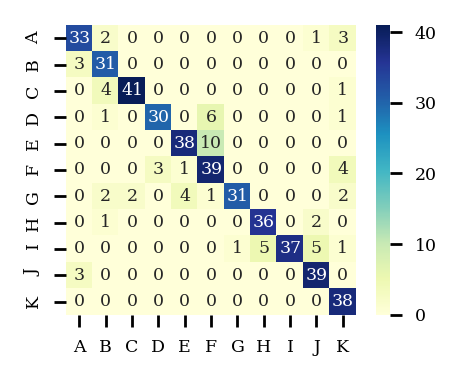